# Projecte CIS-Congres

En aquest notebook s'implementa el scraping de la web del CIS per obtenir els baròmetres de cada mes i després es fa un anàl.lisi dels documents obtinguts per extreure els tòpics que cada mes interessen més als espanyols.

# Scraping CIS

### Mètodes i utilitats

In [1]:
from urllib2 import Request, urlopen, URLError

# Mètode per obtenir una pàgina web
def get_html_page(url_page):
    req = Request(url_page)
    try:
        html_page = urlopen(req)
    except URLError as e:
        if hasattr(e, 'reason'):
            print 'We failed to reach a server. URL: ' + url_page
            print 'Reason: ', e.reason
        elif hasattr(e, 'code'):
            print 'The server couldn\'t fulfill the request. URL: ' + url_page
            print 'Error code: ', e.code
    else:
        # everything is fine
        return html_page

In [2]:
# http://stackoverflow.com/questions/7100125/storing-python-dictionaries

import json
from bson import json_util
import yaml

# http://api.mongodb.org/python/1.10.1/api/bson/json_util.html
# Mètodes per grabar y carregar fitxers en format json
def save_dict_json(dict, filename):
    with open(filename, 'wb') as fp:
        json.dump(dict, fp, default=json_util.default)

def load_dict_json(filename):
    with open(filename, 'rb') as fp:
        return json.load(fp, object_hook=json_util.object_hook)

# http://stackoverflow.com/questions/956867/how-to-get-string-objects-instead-of-unicode-ones-from-json-in-python
def load_dict_yaml(filename):
    with open(filename, 'rb') as fp:
        return yaml.load(fp)
    
# Mètode per grabar un fitxer de texte
def save_text_file(text, file_name, encoding = 'utf-8'):
    with open(file_name, "w") as text_file:
        if encoding:
            text_file.write(text.encode(encoding))
        else:
            text_file.write(text)
            
# Mètode per grabar un fitxer de texte
def save_list_text_file(text_list, file_name):
    with open(file_name, "w") as text_file:
        for item in text_list:
            text_file.write("%s\n" % item)
        
# Mètode per carregar un fitxer de texte
def load_text_file(file_name, encoding = 'utf-8'):
    with open(file_name, "r") as text_file:
        if encoding:
            return text_file.read().decode(encoding)
        else:
            return text_file.read()
        
# Mètode per eliminar caracters incorrectes als noms de fitxers (potser millor utilitzar: https://pypi.python.org/pypi/goldfinch/0.4)
invalid_filename_chars_windows = '\/:*?"<>|'
def del_invalid_chars(value, deletechars):
    for c in deletechars:
        value = value.replace(c,'')
    return value;

import datetime

# Mètode per cambiar de format de data
def format_date(strFecha, format_1, format_2):
    dtDate = datetime.datetime.strptime(strFecha, format_1)
    return dtDate.strftime(format_2)

In [3]:
def get_text_between( s, first, last, include_limits = False, first_ocurrences = True ):
    try:
        if first_ocurrences:
            if include_limits:
                start = s.index( first )
                end = s.rindex( last, start ) + len(last)
                return s[start:end]
            else:
                start = s.index( first ) + len( first )
                end = s.rindex( last, start ) 
            return s[start:end]
        else: 
            # look for last ocurrences of first and last
            if include_limits:
                start = s.rindex( first )
                end = s.index( last ) + len(last)
                return s[start:end]
            else:
                start = s.rindex( first ) + len( first )
                end = s.index( last ) 
            return s[start:end]            
    except ValueError:
        return ""
    
def remove_text_between( s, first, last, include_limits = False ):
    try:
        if include_limits:
            start = s.index( first ) + len( first )
            end = s.index( last, start ) 
            return s[:start] + s[end:] 
        else:
            start = s.index( first )
            end = s.index( last, start ) + len(last)
            return s[:start] + s[end:]
    except ValueError:
        return ""
    
def remove_spaces_and_newline(s):
    return re.sub(r'\s+', ' ', s.replace('\n',''))

In [4]:
# http://stackoverflow.com/questions/22676/how-do-i-download-a-file-over-http-using-python/22776#22776
# http://blog.radevic.com/2012/07/python-download-url-to-file-with.html

import urllib2
import sys

# Mètode per descarregar fitxers d'una url
def download_file(url, file_name, path = "", verbose = False):
    u = urllib2.urlopen(url)
    f = open(path+file_name, 'wb')
    meta = u.info()
    file_size = int(meta.getheaders("Content-Length")[0])
    if verbose:
        print("Downloading: {0} Bytes: {1}".format(url, file_size))

    file_size_dl = 0
    block_sz = 8192
    while True:
        buffer = u.read(block_sz)
        if not buffer:
            break

        file_size_dl += len(buffer)
        f.write(buffer)
        
        if verbose:
            p = float(file_size_dl) / file_size
            status = "\r{0} bytes  [{1:.2%}]".format(file_size_dl, p)
            status = status + chr(8)*(len(status)+1)
            sys.stdout.write(status)
            sys.stdout.flush()

            # done = int(50 * file_size_dl / file_size)
            # sys.stdout.write("\r[%s%s]" % ('=' * done, ' ' * (50-done)) )    
            # sys.stdout.flush()

    f.close()
    print("\n")

# url = 'http://www.pp.es/sites/default/files/documentos/pr_den_2015.pdf'
# file_name = url.split('/')[-1]    
# download_file(url, file_name,'../data/pp/')

In [5]:
# http://stackoverflow.com/questions/26494211/extracting-text-from-a-pdf-file-using-pdfminer-in-python

from pdfminer.pdfinterp import PDFResourceManager, PDFPageInterpreter
from pdfminer.converter import TextConverter
from pdfminer.layout import LAParams
from pdfminer.pdfpage import PDFPage
from cStringIO import StringIO

def convert_pdf_to_txt(path, codec = 'utf-8'):
    rsrcmgr = PDFResourceManager()
    retstr = StringIO()
    laparams = LAParams()
    device = TextConverter(rsrcmgr, retstr, codec=codec, laparams=laparams)
    fp = file(path, 'rb')
    interpreter = PDFPageInterpreter(rsrcmgr, device)
    password = ""
    maxpages = 0
    caching = True
    pagenos=set()

    for page in PDFPage.get_pages(fp, pagenos, maxpages=maxpages, password=password,caching=caching, check_extractable=True):
        interpreter.process_page(page)

    text = retstr.getvalue()

    fp.close()
    device.close()
    retstr.close()
    
    # http://stackoverflow.com/questions/25315566/unicodedecodeerror-in-nltks-word-tokenize-despite-i-forced-the-encoding
    text = text.decode(codec)
    return text

In [79]:
print convert_pdf_to_txt('CIS/docs/19991126_doc.pdf')

 
 
 
 
 
 

 

BARÓMETRO DE NOVIEMBRE 

 

Estudio nº 2.376 
Noviembre 1999 

 
 
 
 
 
 
 
 
 
 
 
 
 

 

 
 
 
 
 
 

 

 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 

 

FICHA TÉCNICA 

BARÓMETRO DE NOVIEMBRE 

 

 

Estudio nº 2.376 
Noviembre 1999 

Noviembre 1999 

 
CIS 
Estudio nº 2.376. Barómetro de noviembre 
 
 
 
 
Ámbito: 
 
Nacional. Se incluyen las provincias insulares y se excluyen Ceuta y Melilla. 
 
 
Universo: 
 
Población española de ambos sexos de 18 años y más. 
 
 
Tamaño de la muestra: 
 
Diseñada: 2.500 entrevistas. 
Realizada: 2.492 entrevistas. 
 
 
Afijación: 
 
Proporcional. 
 
 
Ponderación: 
 
No procede. 
 
 
Puntos de Muestreo: 
 
168 municipios y 46 provincias. 
 
 
Procedimiento de muestreo: 
 
Polietápico,  estratificado  por  conglomerados,  con  selección  de  las  unidades  primarias  de  muestreo 
(municipios) y de las unidades secundarias (secciones) de forma aleatoria proporcional, y de las unidades 
últimas (individuos) p

In [6]:
# http://stackoverflow.com/questions/26494211/extracting-text-from-a-pdf-file-using-pdfminer-in-python

from pdfminer.pdfinterp import PDFResourceManager, PDFPageInterpreter
from pdfminer.converter import TextConverter
from pdfminer.layout import LAParams
from pdfminer.pdfpage import PDFPage
from cStringIO import StringIO

def convert_pdf_from_stream_to_txt(gridFS_result, codec = 'utf-8'):
    rsrcmgr = PDFResourceManager()
    retstr = StringIO()
    laparams = LAParams()
    device = TextConverter(rsrcmgr, retstr, codec=codec, laparams=laparams)
    
    '''
    output=open("CIS/docs/temp_file_001","wb")
    output.write(gridFS_result.read())
    output.close()
    
    fp = file("CIS/docs/temp_file_001", 'rb')
    '''
    fp = gridFS_result
    
    interpreter = PDFPageInterpreter(rsrcmgr, device)
    password = ""
    maxpages = 0
    caching = True
    pagenos=set()

    for page in PDFPage.get_pages(fp, pagenos, maxpages=maxpages, password=password,caching=caching, check_extractable=True):
        interpreter.process_page(page)

    text = retstr.getvalue()

    # fp.close()
    device.close()
    retstr.close()
    
    # http://stackoverflow.com/questions/25315566/unicodedecodeerror-in-nltks-word-tokenize-despite-i-forced-the-encoding
    text = text.decode(codec)
    return text

## Scraping de la web del CIS (Centro de Investigaciones Sociológicas)

### Obtenim el llistat de tots els "Barómetros - Depositados en Banco de Datos" (desde l'actualitat fins 06/04/94: 2087, BARÓMETRO ABRIL 1994)

In [43]:
# http://stackoverflow.com/questions/23377533/python-beautifulsoup-parsing-table

# Búsqueda amb un paràmetre: pàgina
# http://www.cis.es/cis/opencm/ES/11_barometros/depositados.jsp?pagina=1&orden=1&desc=null

# Mime types
# http://www.iana.org/assignments/media-types/media-types.xhtml

from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.support.ui import WebDriverWait
from selenium.common.exceptions import TimeoutException
from selenium.common.exceptions import NoSuchElementException
from bs4 import BeautifulSoup
import re
import os 
import time
import datetime

os.environ["PATH"] = 'C:\Users\pablo_000\Documents\P\Data Science\chromedriver' \
    + os.pathsep + 'C:\Users\pfernandezs\Documents\P\Cosas\Data Science\posgrau\chromedriver'

browser = webdriver.Chrome()

url_CIS = "http://www.cis.es"
delay = 5
element_id = "logos_pie"

num_barometro = 0
continue_scraping = True
web_page = 1
barometro_docs_dict = {}

while continue_scraping :

    url_page = "http://www.cis.es/cis/opencm/ES/11_barometros/depositados.jsp?pagina={}&orden=1&desc=null".format(web_page)
    browser.get(url_page)

    # Wait for the page to load
    # http://selenium-python.readthedocs.org/en/latest/waits.html
    try:
        WebDriverWait(browser, delay).until(EC.presence_of_element_located((By.ID, element_id)))
        # print "Page is ready!"
    except TimeoutException:
        print "Loading took too much time!"
    except NoSuchElementException:
        print "Element id didn't find: " + element_id        

    html_page=browser.page_source

    if html_page is not None:
        print "Parsing: ..." + url_page

        soup = BeautifulSoup(html_page)

        table_resultados = soup.find('table', {'class' : 'resultados'})
        table_resultados_body = table_resultados.find('tbody')
        
        table_resultados_rows = table_resultados_body.findAll('tr')
        
        for row in table_resultados_rows:
            # <td class="fecha">
            td_fecha = row.find('td', {'class' : 'fecha'})
            # <td class="numero">
            td_numero = row.find('td', {'class' : 'numero'})
            # <td class="titulo">
            td_titulo = row.find('td', {'class' : 'titulo'})
            # <td class="ficheros">
            td_ficheros = row.find('td', {'class' : 'ficheros'})
            
            url_barometro = ""
            # <a class="cruces" target="_blank" title='Resultados en html del estudio 3050. Enlace en nueva ventana' 
            # href='/cis/export/sites/default/-Archivos/Marginales/3040_3059/3050/es3050mar.html'>
            a_html = td_ficheros.find('a', attrs={'title': re.compile("^Resultado"), 'href': re.compile(".html$")})
            if a_html:
                url_barometro = url_CIS + a_html['href']
                # raw_doc = get_html_page(url_barometro)
                id_raw_doc = ''
                doc_type = 'text/html'
            else:
                a_pdf = td_ficheros.find('a', attrs={'title': re.compile("^Resultado"), 'href': re.compile(".pdf$")})
                if a_pdf:
                    url_barometro = url_CIS + a_pdf['href']
                    id_raw_doc = ''
                    doc_type = 'application/pdf'
                else:
                    print "Resultado no encontrado:", td_fecha.getText().strip(), "|", \
                        td_numero.getText().strip(), "|", \
                        td_titulo.getText().strip()
                        
            if url_barometro != "":
                barometro_docs_dict[num_barometro] = \
                    {'date': datetime.datetime.strptime(td_fecha.getText().strip(), "%d/%m/%y"), \
                    'number': td_numero.getText().strip(), \
                    'title': td_titulo.getText().strip(), \
                    'url': url_barometro, \
                    'id_raw_doc': id_raw_doc, \
                    'doc_type': doc_type, \
                    'updated_raw_doc': datetime.datetime.utcnow(), \
                    'barometro_dict': {} \
                    }
                num_barometro += 1

    web_page += 1

    if web_page > 8:
        print "Reached web_page limit:", web_page
        continue_scraping = False
    

print "Num. docs:", len(barometro_docs_dict)
# print barometro_docs_dict
print "Saving 'barometro_docs_dict'..."
save_dict_json(barometro_docs_dict, 'barometro_docs_dict.json')

Parsing: ...http://www.cis.es/cis/opencm/ES/11_barometros/depositados.jsp?pagina=1&orden=1&desc=null
Parsing: ...http://www.cis.es/cis/opencm/ES/11_barometros/depositados.jsp?pagina=2&orden=1&desc=null
Resultado no encontrado: 02/11/11 | 2917 | BARÓMETRO NOVIEMBRE 2011
Parsing: ...http://www.cis.es/cis/opencm/ES/11_barometros/depositados.jsp?pagina=3&orden=1&desc=null
Parsing: ...http://www.cis.es/cis/opencm/ES/11_barometros/depositados.jsp?pagina=4&orden=1&desc=null
Parsing: ...http://www.cis.es/cis/opencm/ES/11_barometros/depositados.jsp?pagina=5&orden=1&desc=null
Parsing: ...http://www.cis.es/cis/opencm/ES/11_barometros/depositados.jsp?pagina=6&orden=1&desc=null
Parsing: ...http://www.cis.es/cis/opencm/ES/11_barometros/depositados.jsp?pagina=7&orden=1&desc=null
Parsing: ...http://www.cis.es/cis/opencm/ES/11_barometros/depositados.jsp?pagina=8&orden=1&desc=null
Resultado no encontrado: 18/03/94 | 2085 | BARÓMETRO MARZO 1994
Resultado no encontrado: 22/02/94 | 2083 | BARÓMETRO FEBRERO

A partir de "ABRIL 1994" no es troben els resultats del baròmetre:

    Resultado no encontrado: 18/03/94 | 2085 | BARÓMETRO MARZO 1994
    Resultado no encontrado: 22/02/94 | 2083 | BARÓMETRO FEBRERO 1994
    Resultado no encontrado: 12/01/94 | 2077 | BARÓMETRO ENERO 1994
    Resultado no encontrado: 16/12/93 | 2076 | BARÓMETRO DICIEMBRE 1993
    Resultado no encontrado: 26/11/93 | 2073 | BARÓMETRO NOVIEMBRE 1993
    Resultado no encontrado: 13/10/93 | 2068 | BARÓMETRO OCTUBRE 1993
    Resultado no encontrado: 21/09/93 | 2066 | BARÓMETRO SEPTIEMBRE 1993
    Resultado no encontrado: 24/07/93 | 2065 | BARÓMETRO JULIO 1993
    Resultado no encontrado: 25/06/93 | 2062 | BARÓMETRO JUNIO 1993
    Resultado no encontrado: 15/05/93 | 2059 | BARÓMETRO MAYO 1993
    Resultado no encontrado: 24/04/93 | 2055 | BARÓMETRO ABRIL 1993: PREELECTORAL ELECCIONES GENERALES 1993 (II)

Per tant, només hi ha un problema amb el baròmetre de "NOVIEMBRE 2011".  L'afegirem a mà al diccionari:

In [44]:
# http://www.cis.es/cis/opencm/ES/11_barometros/depositados.jsp?pagina=2&orden=1&desc=null

# <a class="cruces" target="_blank" title='Mapa para seleccionar muestras en html del estudio 2917. Enlace en nueva ventana' href='/cis/export/sites/default/-Archivos/Marginales/2900_2919/2917/Es2917_mapa.htm'>
# 'href' -> http://www.cis.es/cis/export/sites/default/-Archivos/Marginales/2900_2919/2917/Es2917_mapa.htm
'''
<!--Total nacional 00-->
<area shape="rect" coords="153,05,279,20"
 title="Muestra NACIONAL. Enlace a resultados y ficha técnica en formato html"
 href="e291700.html" target="_self" alt="Muestra NACIONAL. Enlace a resultados y ficha técnica en formato html" />

<!--País Vasco 01-->
<area shape="rect" coords="214,76,303,92"
 title="Muestra del PAÍS VASCO. Enlace a resultados y ficha técnica en formato html"
 href="e291701.html" target="_self" alt="Muestra del PAÍS VASCO. Enlace a resultados y ficha técnica en formato html" />
'''
# Ens quedem amb els resultats 'Total nacional':
url_barometro = "http://www.cis.es/cis/export/sites/default/-Archivos/Marginales/2900_2919/2917/e291700.html"

num_barometro = len(barometro_docs_dict)

barometro_docs_dict[num_barometro] = \
                    {'date': datetime.datetime.strptime('02/11/11', "%d/%m/%y"), \
                    'number': '2917', \
                    'title': 'BARÓMETRO NOVIEMBRE 2011', \
                    'url': url_barometro, \
                    'id_raw_doc': '', \
                    'doc_type': 'text/html', \
                    'updated_raw_doc': datetime.datetime.utcnow(), \
                    'barometro_dict': {} \
                    }
    
print "Num. docs:", len(barometro_docs_dict)
# print barometro_docs_dict
print "Saving 'barometro_docs_dict'..."
save_dict_json(barometro_docs_dict, 'barometro_docs_dict.json')

Num. docs: 229
Saving 'barometro_docs_dict'...


#### Estadística dels tipus de docs obtinguts:

In [7]:
#
loaded_barometro_docs_dict = load_dict_json('barometro_docs_dict.json')
print "Num. of docs:", len(loaded_barometro_docs_dict)
docs_type_html = 0
docs_type_pdf = 0
docs_type_others = 0
for key in loaded_barometro_docs_dict:
    if loaded_barometro_docs_dict[key]['doc_type'] == 'text/html':
        docs_type_html += 1
    elif loaded_barometro_docs_dict[key]['doc_type'] == 'application/pdf':
        docs_type_pdf += 1
    else:
        docs_type_others += 1

print "Num. docs_type_html:", docs_type_html, ",", (100.*docs_type_html/len(loaded_barometro_docs_dict)), "%"
print "Num. docs_type_pdf:", docs_type_pdf, ",", (100.*docs_type_pdf/len(loaded_barometro_docs_dict)), "%"
print "Num. docs_type_others:", docs_type_others, ",", (100.*docs_type_others/len(loaded_barometro_docs_dict)), "%"

Num. of docs: 229
Num. docs_type_html: 215 , 93.8864628821 %
Num. docs_type_pdf: 14 , 6.1135371179 %
Num. docs_type_others: 0 , 0.0 %


### Creació de la base de dades del CIS

#### Estructura del diccionari de documents

In [ ]:
'''
barometro_docs_dict = {
    'date': <data del document (barómetro del CIS)>,
    'number': <número identificador del document (CIS)>,
    'title': <títol del document (CIS)>,
    'url': <url del document>,
    'id_raw_doc': <id del fitxer amb el contingut del document (sense tractar)>,
    'doc_type': <'html' | 'pdf'>,
    'updated_raw_doc': <data d'actualització del camp 'id_raw_doc'>,
    'barometro_dict': <diccionari amb les preguntes i resultats del baròmetre>,
    'updated_barometro_dict': <data d'actualització del camp 'barometro_dict'>
}

barometro_dict = {

}
'''

#### Obrir conexió a la BD 'CIS'

In [7]:
import pymongo

# Create the connection to MongoDB
try:
    connection=pymongo.MongoClient()
    print "Connection to Mongo Daemon successful!!!"
except pymongo.errors.ConnectionFailure, e:
    print "Could not connect to MongoDB: %s" % e
    
# Obtenim la BD del Congrés
db = connection['CIS']
#
print "Collections:", db.collection_names()

Connection to Mongo Daemon successful!!!
Collections: [u'system.indexes', u'barometro_docs', u'barometro_docs.chunks', u'barometro_docs.files', u'barometro_topics']


Check the database status http://127.0.0.1:28017/

#### Tancar la conexió a la BD

In [49]:
connection.close()

#### Guardem el diccionari dels baròmetres

In [47]:
#
collection = db['barometro_docs']
collection.drop()

#
loaded_barometro_docs_dict = load_dict_json('barometro_docs_dict.json')
print "num. of docs:", len(loaded_barometro_docs_dict)
for key in loaded_barometro_docs_dict:
    collection.insert(loaded_barometro_docs_dict[key])

#
print "num. of rows: ", collection.count()
for doc in collection.find():
    print doc

num. of docs: 229
num. of rows:  229
{u'doc_type': u'text/html', u'id_raw_doc': u'', u'title': u'BAR\xd3METRO ABRIL 1995', u'url': u'http://www.cis.es/cis/export/sites/default/-Archivos/Marginales/2140_2159/2156/e215600.html', u'barometro_dict': {}, u'number': u'2156', u'date': datetime.datetime(1995, 4, 19, 0, 0), u'_id': ObjectId('5528dd7c7c4c6704c43c96c6'), u'updated_raw_doc': datetime.datetime(2015, 4, 11, 8, 34, 22, 496000)}
{u'doc_type': u'text/html', u'id_raw_doc': u'', u'title': u'BAR\xd3METRO MARZO 1995', u'url': u'http://www.cis.es/cis/export/sites/default/-Archivos/Marginales/2140_2159/2151/e215100.html', u'barometro_dict': {}, u'number': u'2151', u'date': datetime.datetime(1995, 3, 19, 0, 0), u'_id': ObjectId('5528dd7c7c4c6704c43c96c7'), u'updated_raw_doc': datetime.datetime(2015, 4, 11, 8, 34, 22, 496000)}
{u'doc_type': u'text/html', u'id_raw_doc': u'', u'title': u'BAR\xd3METRO JUNIO 1995', u'url': u'http://www.cis.es/cis/export/sites/default/-Archivos/Marginales/2180_2199

In [44]:
# Per previndre aquest l'error: Overflow sort stage buffered data usage exceeds internal limit
# indexem el camp 'date' de la collection 'barometro_docs'
# http://stackoverflow.com/questions/27023622/overflow-sort-stage-buffered-data-usage-exceeds-internal-limit
#
barometro_docs_collection = db['barometro_docs']

from pymongo import ASCENDING, DESCENDING

barometro_docs_collection.create_index([("date", ASCENDING)])

u'date_1'

### Scraping per descarregar les dades dels baròmetres del CIS

In [43]:
# Mètode per descarregar els documents del diccionari 'barometro_docs_dict'

import urllib
import os
import datetime
# http://api.mongodb.org/python/current/api/gridfs/index.html
# http://api.mongodb.org/python/current/examples/gridfs.html
# -->  http://dirolf.com/2010/03/29/new-gridfs-implementation-for-pymongo.html
# http://blog.pythonisito.com/2012/05/gridfs-mongodb-filesystem.html
import gridfs

# https://docs.python.org/2/library/mimetypes.html
def get_extension(doc_type):
    if doc_type == 'text/html':
        return 'html'
    elif doc_type == 'application/pdf':
        return 'pdf'
    else:
        return ''

# http://stackoverflow.com/questions/20551602/saving-a-file-in-mongodbs-gridfs-with-pymongo-results-in-a-truncated-file-pyt
def get_open_file_mode(doc_type):
    if doc_type == 'text/html':
        return 'r'
    elif doc_type == 'application/pdf':
        return 'rb'
    else:
        return ''
        
def save_from_url_doc(url_doc, doc_type, file_name, path):
    if doc_type == 'text/html':
        url_opener = urllib.URLopener()
        url_opener.retrieve(url_doc, path + file_name)
    elif doc_type == 'application/pdf':
        download_file(url_doc, file_name, path = path)
    else:
        ''

def download_docs_to_DB(barometro_docs, my_gridFS, overwrite = False):
    
    # for doc in barometro_docs.find({'doc_type': 'application/pdf'})[:1]:
    for doc in barometro_docs.find():
        print "Doc:", doc['title']
        if doc['id_raw_doc']=="" or overwrite:
            print "Loading: ...", doc['url']
            
            file_name = doc['date'].strftime("%Y%m%d") + "_doc." + get_extension(doc['doc_type'])
            print "Saving...", file_name
            save_from_url_doc(doc['url'], doc['doc_type'], file_name, "CIS/docs/")
            
            with open("CIS/docs/"+file_name, get_open_file_mode(doc['doc_type'])) as my_doc:
                id_raw_doc = my_gridFS.put(my_doc, content_type=doc['doc_type'], filename=file_name)
            
            # http://docs.mongodb.org/manual/tutorial/modify-documents/
            barometro_docs.update({'_id':doc['_id']},{'$set':{'id_raw_doc':id_raw_doc, 'updated_raw_doc': datetime.datetime.utcnow()}}, \
                                  upsert=False, multi=False)

#
barometro_docs_collection = db['barometro_docs']

fs = gridfs.GridFS(db, 'barometro_docs')

download_docs_to_DB(barometro_docs_collection, fs, overwrite = True)


 Doc: BARÓMETRO ABRIL 1995
Loading: ... http://www.cis.es/cis/export/sites/default/-Archivos/Marginales/2140_2159/2156/e215600.html
Saving... 19950419_doc.html
Doc: BARÓMETRO MARZO 1995
Loading: ... http://www.cis.es/cis/export/sites/default/-Archivos/Marginales/2140_2159/2151/e215100.html
Saving... 19950319_doc.html
Doc: BARÓMETRO JUNIO 1995
Loading: ... http://www.cis.es/cis/export/sites/default/-Archivos/Marginales/2180_2199/2184/e218400.html
Saving... 19950625_doc.html
Doc: BARÓMETRO MAYO 1995
Loading: ... http://www.cis.es/cis/export/sites/default/-Archivos/Marginales/2180_2199/2181/e218100.html
Saving... 19950525_doc.html
Doc: BARÓMETRO SEPTIEMBRE 1995
Loading: ... http://www.cis.es/cis/export/sites/default/-Archivos/Marginales/2180_2199/2190/e219000.html
Saving... 19950913_doc.html
Doc: BARÓMETRO JULIO 1995: UNIÓN EUROPEA
Loading: ... http://www.cis.es/cis/export/sites/default/-Archivos/Marginales/2180_2199/2188/e218800.html
Saving... 19950712_doc.html
Doc: BARÓMETRO NOVIEMBRE 1

#### Llistat de fitxers enmagatzemats a GridFS(db, 'barometro_docs') 

In [55]:
from gridfs import GridFS

#
fs = GridFS(db, 'barometro_docs')

print "Núm. docs:", len(fs.list())
print fs.list()

Núm. docs: 229
[u'CIS/docs/19940406_doc.html', u'CIS/docs/19940512_doc.html', u'CIS/docs/19940616_doc.html', u'CIS/docs/19940701_doc.html', u'CIS/docs/19940920_doc.html', u'CIS/docs/19941019_doc.html', u'CIS/docs/19941112_doc.html', u'CIS/docs/19941201_doc.html', u'CIS/docs/19950112_doc.html', u'CIS/docs/19950202_doc.html', u'CIS/docs/19950319_doc.html', u'CIS/docs/19950419_doc.html', u'CIS/docs/19950525_doc.html', u'CIS/docs/19950625_doc.html', u'CIS/docs/19950712_doc.html', u'CIS/docs/19950913_doc.html', u'CIS/docs/19951017_doc.html', u'CIS/docs/19951108_doc.html', u'CIS/docs/19951209_doc.html', u'CIS/docs/19960110_doc.html', u'CIS/docs/19960227_doc.html', u'CIS/docs/19960327_doc.html', u'CIS/docs/19960413_doc.html', u'CIS/docs/19960529_doc.html', u'CIS/docs/19960622_doc.html', u'CIS/docs/19960717_doc.html', u'CIS/docs/19960927_doc.html', u'CIS/docs/19961026_doc.html', u'CIS/docs/19961123_doc.html', u'CIS/docs/19961217_doc.html', u'CIS/docs/19970123_doc.html', u'CIS/docs/19970222_doc

In [54]:
# delete example
filename = '19991126_doc.pdf'
if fs.exists(filename = filename):
    fp = fs.get_last_version(filename)
    print fp.filename, "id:", fp._id, "upload_date:", fp.upload_date
    print "Deleting...", filename
    fs.delete(fp._id)
else:
    print filename, "not exists"

19991126_doc.pdf id: 552900127c4c6704c43c97ae upload_date: 2015-04-11 11:05:54.454000
Deleting... 19991126_doc.pdf


### Scraping i extracció de les dades dels documents

In [60]:
from gridfs import GridFS

#
barometro_docs_collection = db['barometro_docs']
fs = GridFS(db, 'barometro_docs')

doc_start_date = "01/01/1993"
d_doc_start_date = datetime.datetime.strptime(doc_start_date, "%d/%m/%Y")
d_doc_end_date = datetime.datetime.utcnow()
result = barometro_docs_collection.find({'date': {'$gte': d_doc_start_date, '$lte': d_doc_end_date}}).sort('date',DESCENDING)

if result.count() > 0 :
    print "Num. of docs:", result.count()
    for doc in result:
        print "Doc. id:", doc['_id'], ", id_raw_doc:", doc['id_raw_doc'], ", date:", doc['date']
        '''
        # Getting file contents
        if doc['doc_type'] == 'text/html':
            print fs.get(doc['id_raw_doc']).read()
        elif 'application/pdf':
            print ">" + convert_pdf_from_stream_to_txt(fs.get(doc['id_raw_doc'])) + "<"
        '''

Num. of docs: 229
Doc. id: 5528dd7c7c4c6704c43c96e8 , id_raw_doc: 552977cf7c4c671ab08e5dca , date: 2015-01-02 00:00:00
Doc. id: 5528dd7c7c4c6704c43c9791 , id_raw_doc: 552978907c4c671ab08e5f9b , date: 2014-12-01 00:00:00
Doc. id: 5528dd7c7c4c6704c43c9754 , id_raw_doc: 5529784d7c4c671ab08e5ef1 , date: 2014-11-04 00:00:00
Doc. id: 5528dd7c7c4c6704c43c9723 , id_raw_doc: 552978167c4c671ab08e5e72 , date: 2014-10-01 00:00:00
Doc. id: 5528dd7c7c4c6704c43c96e9 , id_raw_doc: 552977d07c4c671ab08e5dcd , date: 2014-09-02 00:00:00
Doc. id: 5528dd7c7c4c6704c43c9792 , id_raw_doc: 552978917c4c671ab08e5f9e , date: 2014-07-01 00:00:00
Doc. id: 5528dd7c7c4c6704c43c9758 , id_raw_doc: 552978517c4c671ab08e5efb , date: 2014-06-02 00:00:00
Doc. id: 5528dd7c7c4c6704c43c9725 , id_raw_doc: 552978187c4c671ab08e5e78 , date: 2014-05-01 00:00:00
Doc. id: 5528dd7c7c4c6704c43c96ea , id_raw_doc: 552977d17c4c671ab08e5dd0 , date: 2014-04-01 00:00:00
Doc. id: 5528dd7c7c4c6704c43c9793 , id_raw_doc: 552978927c4c671ab08e5fa1 

### Scraping per extreure la informació dels documents del baròmetre

In [116]:
# Mètode que elimina els caracters no alfanumèrics d'un text
def remove_non_alphanumeric_chars(text):
    return re.compile('\s+').sub(' ', text).strip()

#### parse_barometer_CIS_doc: Mètode per extreure la informació dels documents desde l'actualitat fins setembre de 2013

In [118]:
from bs4 import BeautifulSoup
import re


def parse_barometer_CIS_doc(html_doc, verbose = False):
    # html_doc = get_html_page(url_doc)

    soup = BeautifulSoup(html_doc)

    # <p style="font-family: Arial Narrow; font-size: 12pt;"><b>Pregunta 7 </b><br>
    # ¿Cuál es, a su juicio, el principal problema que existe actualmente en España? ¿Y el segundo? ¿Y el tercero? (MULTIRRESPUESTA).</p>

    # 
    question_to_search = u"principal problema que existe actualmente"
    question_type_to_search = u"MULTIRRESPUESTA"

    question_topics_values = []
    i = 0
    for found in soup.body.findAll(text=re.compile('^Pregunta\s*\d+')):
        question = remove_non_alphanumeric_chars(found.parent.parent.contents[2])
        if (question_to_search in question and question_type_to_search in question):
            if verbose:
                print "-------------------------------------------------"
                print i, ":", remove_non_alphanumeric_chars(found), "-->", question
                print "-------------------------------------------------"

            table_p = found.find_next('table')
            table_p_body = table_p.find('tbody')
            if table_p_body:
                table_p_rows = table_p_body.findAll('tr')
            else:
                table_p_rows = table_p.findAll('tr')

            for row in table_p_rows:
                f_td = row.find_next('td')
                topic = remove_non_alphanumeric_chars(f_td.getText())
                if "(N)" not in topic:
                    f_td = f_td.find_next('td')
                    value = float(f_td.getText().replace(',','.'))
                    question_topics_values.append((topic,value))
                    # print topic, "-->", value
        i += 1

    # Obtenim una llista de tuples, cada tupla té dos valors: 'el problema' i el percentatge 
    # Ordenem la llista 'question_topics_value' per percentatge
    question_topics_values.sort(key=lambda tup: tup[1], reverse=True)
    
    return question_topics_values


#### parse_barometer_CIS_doc_v2: Mètode per extreure la informació dels documents desde setembre de 2013

In [91]:
def parse_barometer_CIS_doc_v2(html_doc, verbose = False):
    # html_doc = get_html_page(url_doc)

    soup = BeautifulSoup(html_doc)

    # <p style="font-family: Arial Narrow; font-size: 12pt;"><b>Pregunta 7 </b><br>
    # ¿Cuál es, a su juicio, el principal problema que existe actualmente en España? ¿Y el segundo? ¿Y el tercero? (MULTIRRESPUESTA).</p>

    # 
    question_to_search = u"principal problema que existe actualmente"
    question_type_to_search = u"MULTIRRESPUESTA"
    # Es podrien incloure altres literals: "Otras respuestas", "N.S.", "N.C.", ...
    stopwords = ["TOTAL", "(N)"]

    question_topics_values = []
    
    found_question = False
    found_question_type = False
    
    # Cerquem la taula que conte la pregunta que conté: "principal problema que existe actualmente" y "MULTIRRESPUESTA"
    table_questions = soup.findAll('table', {'class' : 'SysTitleAndFooterContainer'})
    
    found_element = None
    for table_q in table_questions:
        table_q_body = table_q.find('tbody')
        if table_q_body:
            table_q_rows = table_q_body.findAll('tr')
        else:
            table_q_rows = table_q.findAll('tr')

        for row in table_q_rows:
            f_td = row.find_next('td')
            if question_to_search in remove_non_alphanumeric_chars(f_td.getText()):
                question_found_text = remove_non_alphanumeric_chars(f_td.getText())
                found_question = True
            if question_type_to_search in remove_non_alphanumeric_chars(f_td.getText()):
                question_type_found_text = remove_non_alphanumeric_chars(f_td.getText())
                found_question_type = True
        if found_question and found_question_type:
            found_element = table_q
            if verbose:
                print "-------------------------------------------------"
                print "Question:", question_found_text, question_type_found_text
                print "-------------------------------------------------"            
            break
    
    # Si hem trobat la taula que conte la pregunta desitjada, obtenim els valors de la taula següent
    if found_element:
        table_p = found_element.find_next('table')
        table_p_body = table_p.find('tbody')
        if table_p_body:
            table_p_rows = table_p_body.findAll('tr')
        else:
            table_p_rows = table_p.findAll('tr')        
        
        for row in table_p_rows:
            f_th = row.find_next('th')
            topic = remove_non_alphanumeric_chars(f_th.getText())
            if all(stopword not in topic for stopword in stopwords):
                row_tds = row.findAll('td')
                if len(row_tds) > 2:
                    # taula del tipus: Primer problema | Segundo problema | Tercer problema | Total
                    f_td = row_tds[3]
                else:
                    # taula del tipus: . % | . (N)
                    f_td = row_tds[0]
                value = float(f_td.getText().replace(',','.'))
                question_topics_values.append((topic,value))
        
    # Obtenim una llista de tuples, cada tupla té dos valors: 'el problema' i el percentatge 
    # Ordenem la llista 'question_topics_value' per percentatge
    question_topics_values.sort(key=lambda tup: tup[1], reverse=True)
    
    return question_topics_values


#### parse_barometer_CIS_doc_v3: Mètode per extreure la informació dels documents desde setembre de 2013 (que no han donat resultats amb parse_barometer_CIS_doc_v2)

In [114]:
def all_question_words_found(words_list):
    for word in words_list:
        if not word[1]:
            return False
    return True

def reset_question_words_list(words_list):
    for word in words_list:
        word[1] = False

def parse_barometer_CIS_doc_v3(html_doc, verbose = False):
    # html_doc = get_html_page(url_doc)

    soup = BeautifulSoup(html_doc)

    # <p style="font-family: Arial Narrow; font-size: 12pt;"><b>Pregunta 7 </b><br>
    # ¿Cuál es, a su juicio, el principal problema que existe actualmente en España? ¿Y el segundo? ¿Y el tercero? (MULTIRRESPUESTA).</p>

    # 
    question_words_to_search = [[u"principal",False],[u"problema",False],[u"existe",False],[u"actualmente",False]]
    question_words_text_found = ""
    # Hi ha un problema al comparar amb paraules amb espais, p.e. "MÁXIMO TRES RESPUESTAS"...  perque el document està codificat:
    # <b>¿Cuáles&nbsp;son,&nbsp;a&nbsp;su&nbsp;juicio,&nbsp;los&nbsp;tres&nbsp;problemas&nbsp;principales&nbsp;que&nbsp;existen&nbsp;actualmente&nbsp;en&nbsp;España?&nbsp;</b>
    # [...]
    # <font  face="Arial, Helvetica, Helv" size="3" color="#002288"><b>(MÁXIMO&nbsp;TRES&nbsp;RESPUESTAS).</b></font>
    # Potser es pot fer servir: http://www.crummy.com/software/BeautifulSoup/bs4/doc/#output-formatters
    # question_types_to_search = [u"MULTIRRESPUESTA",u"MÁXIMO TRES RESPUESTAS"]
    question_types_to_search = [u"MULTIRRESPUESTA",u"MÁXIMO"]
        
    found_question_type = False
    
    # Es podrien incloure altres literals: "Otras respuestas", "N.S.", "N.C.", ...
    stopwords = ["TOTAL", "(N)"]

    question_topics_values = []

    
    # Cerquem la taula que conte la pregunta que conté: "principal problema que existe actualmente" y "MULTIRRESPUESTA"
    table_questions = soup.findAll('table')
    
    if len(table_questions) > 0:
        found_element = None
        for table_q in table_questions:
            table_q_body = table_q.find('tbody')
            if table_q_body:
                table_q_rows = table_q_body.findAll('tr')
            else:
                table_q_rows = table_q.findAll('tr')

            for row in table_q_rows:
                f_td = row.find_next('td')
                cleaned_td_text = remove_non_alphanumeric_chars(f_td.getText())
                #
                any_question_word_found = False
                for question_word in question_words_to_search:
                    if question_word[0] in cleaned_td_text:
                        question_word[1] = True
                        any_question_word_found = True
                if any_question_word_found:
                    question_words_text_found += "\n" + cleaned_td_text
                #
                if any(question_type in cleaned_td_text for question_type in question_types_to_search):
                    question_type_found_text = cleaned_td_text
                    print cleaned_td_text
                    found_question_type = True
            if all_question_words_found(question_words_to_search) and found_question_type:
                found_element = table_q
                if verbose:
                    print "-------------------------------------------------"
                    print "Question:", question_words_text_found, question_type_found_text
                    print "-------------------------------------------------"            
                break
            elif all_question_words_found(question_words_to_search):
                found_element = table_q
                reset_question_words_list(question_words_to_search)
            else:
                reset_question_words_list(question_words_to_search)
                found_question_type = False

        # Si hem trobat la taula que conte la pregunta desitjada, obtenim els valors de la taula següent amb {'rules':'groups'}
        if found_element:
            table_p = found_element.find_next('table', attrs={'rules':re.compile("^groups$", re.I)})
            if table_p:
                table_p_body = table_p.find('tbody')
                if table_p_body:
                    table_p_rows = table_p_body.findAll('tr')
                else:
                    table_p_rows = table_p.findAll('tr')        

                for row in table_p_rows:
                    f_th = row.find_next('th')
                    value_index = 0
                    if not f_th:
                        f_th = row.find_next('td')
                        value_index = 1
                    topic = remove_non_alphanumeric_chars(f_th.getText())
                    # print ">" + topic + "<"
                    if topic!="" and all(stopword not in topic for stopword in stopwords):
                        row_tds = row.findAll('td')
                        if len(row_tds) > 3:
                            # taula del tipus: Primer problema | Segundo problema | Tercer problema | Total
                            f_td = row_tds[3]
                        else:
                            # taula del tipus: <topics> | . % | . (N)
                            f_td = row_tds[value_index]
                        value = float(f_td.getText().replace(',','.'))
                        question_topics_values.append((topic,value))
            else:
                if verbose:
                    print "'table', attrs={'rules':re.compile('^groups$', re.I)}:", "not found"                
        else:
            if verbose:
                print "Question words:", question_words_to_search, "not found"

        # Obtenim una llista de tuples, cada tupla té dos valors: 'el problema' i el percentatge 
        # Ordenem la llista 'question_topics_value' per percentatge
        question_topics_values.sort(key=lambda tup: tup[1], reverse=True)
    else:
        if verbose:
            print "Element not found: 'table', {'class' : 'SysTitleAndFooterContainer'}"
    
    return question_topics_values

#### Procés per a la extracció de la informació dels documents del baròmetre (actualitza la BBDD)

In [120]:
from gridfs import GridFS

#
barometro_docs_collection = db['barometro_docs']
fs = GridFS(db, 'barometro_docs')

doc_format_change = "01/10/2013"
d_doc_format_change = datetime.datetime.strptime(doc_format_change, "%d/%m/%Y")

doc_start_date = "01/01/1993"
d_doc_start_date = datetime.datetime.strptime(doc_start_date, "%d/%m/%Y")
d_doc_end_date = datetime.datetime.utcnow()
result = barometro_docs_collection.find({'date': {'$gte': d_doc_start_date, '$lte': d_doc_end_date}}).sort('date',DESCENDING)

if result.count() > 0 :
    print "Num. of docs:", result.count()
    
    for doc in result:
        if doc['doc_type'] == 'text/html':
            print "\n", doc['title'], ", date:", doc['date'], ", doc_type:", doc['doc_type']
            print "URL:", doc['url']

            parse_results = []
            if doc['date'] > d_doc_format_change:
                parse_results =  parse_barometer_CIS_doc(fs.get(doc['id_raw_doc']).read(), True)
                if len(parse_results) > 0:
                    print parse_results
                else:
                    print "No results."
            else:
                parse_results =  parse_barometer_CIS_doc_v2(fs.get(doc['id_raw_doc']).read(), True)
                if len(parse_results) > 0:
                    print parse_results
                else:
                    parse_results =  parse_barometer_CIS_doc_v3(fs.get(doc['id_raw_doc']).read(), True)
                    if len(parse_results) > 0:
                        print parse_results
                    else:
                        print "No results."
                        
            # http://docs.mongodb.org/manual/tutorial/modify-documents/
            barometro_docs_collection.update({'_id':doc['_id']}, \
                       {'$set':{'barometro_dict':parse_results, 'updated_barometro_dict':datetime.datetime.utcnow()}}, \
                       upsert=False, multi=False)

        elif doc['doc_type'] == 'application/pdf':
            print doc['title'], ", date:", doc['date'], ", doc_type:", doc['doc_type']
            print "Under construction."
            # print ">" + convert_pdf_from_stream_to_txt(fs.get(doc['id_raw_doc'])) + "<"

        else:
            print "Unknown doc_type:", doc['doc_type']


Num. of docs: 229

BARÓMETRO DE ENERO 2015 , date: 2015-01-02 00:00:00 , doc_type: text/html
URL: http://www.cis.es/cis/export/sites/default/-Archivos/Marginales/3040_3059/3050/es3050mar.html
-------------------------------------------------
9 : Pregunta 7A --> ¿Cuál es, a su juicio, el principal problema que existe actualmente en España? ¿Y el segundo? ¿Y el tercero? (MULTIRRESPUESTA).
-------------------------------------------------
[(u'El paro', 79.4), (u'La corrupci\xf3n y el fraude', 55.5), (u'Los problemas de \xedndole econ\xf3mica', 24.5), (u'Los/as pol\xedticos/as en general, los partidos y la pol\xedtica', 21.8), (u'La sanidad', 10.2), (u'Los problemas de \xedndole social', 9.8), (u'La educaci\xf3n', 7.1), (u'Otras respuestas', 4.6), (u'Los problemas relacionados con la calidad del empleo', 3.7), (u'"Los recortes"', 3.4), (u'El Gobierno y partidos o pol\xedticos/as concretos', 2.8), (u'La inseguridad ciudadana', 2.6), (u'La inmigraci\xf3n', 2.3), (u'La Administraci\xf3n de Ju

#### Estadística dels resultats obtinguts

In [9]:
from gridfs import GridFS
from pymongo import ASCENDING, DESCENDING

#
barometro_docs_collection = db['barometro_docs']
fs = GridFS(db, 'barometro_docs')

result = barometro_docs_collection.find().sort('date',DESCENDING)

if result.count() > 0 :
    num_docs = result.count()
    num_docs_without_results = 0
    print "Num. of docs:", num_docs
    
    doc_list = []
    for doc in result:
        doc_list.append((doc['date'], len(doc['barometro_dict'])))
        print "\n", doc['title'], ", date:", doc['date'], ", doc_type:", doc['doc_type']
        print "URL:", doc['url']
        if len(doc['barometro_dict']) > 0:
            print "len(doc['barometro_dict']) =", len(doc['barometro_dict'])
        else:
            print "No results."
            num_docs_without_results += 1
    print "\n-------------------------------------------"
    print "Num. of docs:", num_docs
    print "Num. of docs with results:", num_docs - num_docs_without_results
    print "Num. of docs without results:", num_docs_without_results, ",", float(100*num_docs_without_results/num_docs), "%"
    print "Num. of docs without results (without pdfs):", num_docs_without_results-14, ",", float(100*(num_docs_without_results-14)/num_docs), "%"
    print "-------------------------------------------\n"

Num. of docs: 229

BARÓMETRO DE ENERO 2015 , date: 2015-01-02 00:00:00 , doc_type: text/html
URL: http://www.cis.es/cis/export/sites/default/-Archivos/Marginales/3040_3059/3050/es3050mar.html
len(doc['barometro_dict']) = 42

BARÓMETRO DE DICIEMBRE 2014 , date: 2014-12-01 00:00:00 , doc_type: text/html
URL: http://www.cis.es/cis/export/sites/default/-Archivos/Marginales/3040_3059/3047/es3047mar.html
len(doc['barometro_dict']) = 42

BARÓMETRO DE NOVIEMBRE 2014 , date: 2014-11-04 00:00:00 , doc_type: text/html
URL: http://www.cis.es/cis/export/sites/default/-Archivos/Marginales/3040_3059/3045/es3045mar.html
len(doc['barometro_dict']) = 41

BARÓMETRO DE OCTUBRE 2014 , date: 2014-10-01 00:00:00 , doc_type: text/html
URL: http://www.cis.es/cis/export/sites/default/-Archivos/Marginales/3040_3059/3041/es3041mar.html
len(doc['barometro_dict']) = 44

BARÓMETRO DE SEPTIEMBRE 2014 , date: 2014-09-02 00:00:00 , doc_type: text/html
URL: http://www.cis.es/cis/export/sites/default/-Archivos/Marginales

Desde: 2015-04-20 00:00:00 , fins: 1994-04-06 00:00:00 , dies: 7684
Desde: 2015-04-20 00:00:00 , fins: 1994-04-06 00:00:00 , mesos: 252


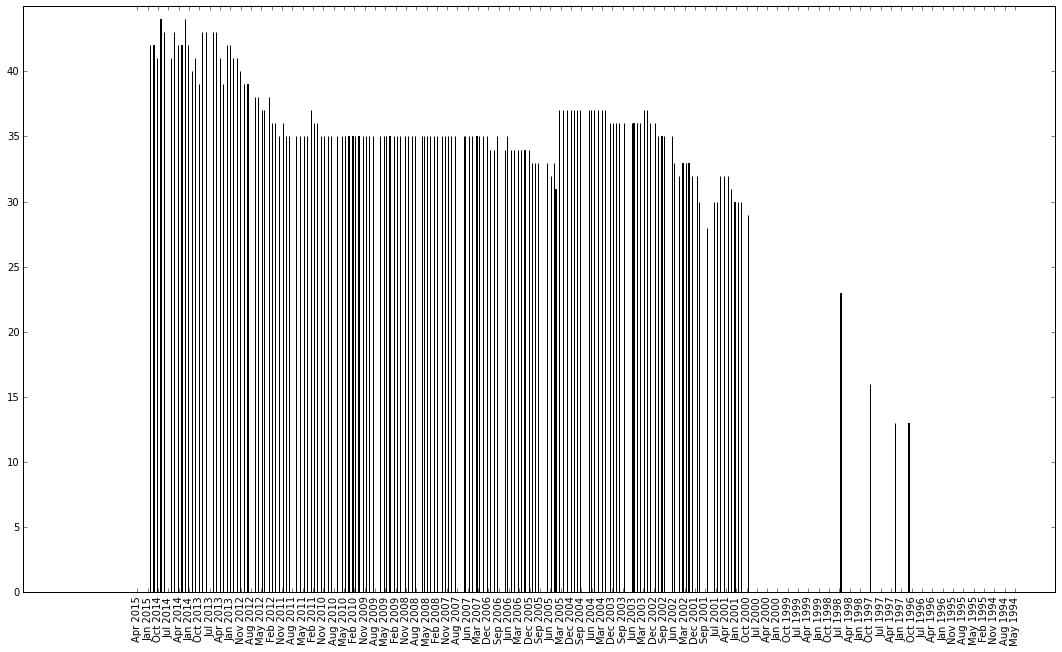

In [10]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import collections

from calendar import monthrange
from datetime import datetime, timedelta

# http://stackoverflow.com/questions/7015587/python-difference-of-2-datetimes-in-months
def monthdelta(d1, d2):
    delta = 0
    while True:
        mdays = monthrange(d1.year, d1.month)[1]
        d1 += timedelta(days=mdays)
        if d1 <= d2:
            delta += 1
        else:
            break
    return delta

base = datetime.today().replace(hour=0, minute=0, second=0, microsecond=0)
num_days = (base-doc_list[-1][0]).days
num_months = monthdelta(doc_list[-1][0], base)
print "Desde:", base, ", fins:", doc_list[-1][0], ", dies:", num_days
print "Desde:", base, ", fins:", doc_list[-1][0], ", mesos:", num_months

date_list = [base - timedelta(days=x) for x in range(0, num_days+1)]
# print date_num_topics_list
       
all_days_dict = collections.OrderedDict(zip(date_list, [0]*len(date_list)))
# print all_days_dict

for doc in doc_list:
    if doc[0] in all_days_dict:
        all_days_dict[doc[0]]=doc[1]
# print all_days_dict

# Plot frequency bar chart num. topics per day
xticks_freq = 90
yticks_freq = 5
barcolor = 'blue'

# Get xticks month labels 
i = 0
xticks_labels = []
for key in all_days_dict:
    if i % xticks_freq == 0:
        xticks_labels.append(key.strftime("%b %Y"))
    i+=1
# print xticks_labels

# Get yticks num. docs labels
yticks_labels = []
for i in range(0,max(all_days_dict.values())+1):
    if i % yticks_freq == 0:
        yticks_labels.append(str(i))
# print yticks_labels

# Start plot
fig, ax = plt.subplots()
fig.set_size_inches(18.5,10.5)
# fig.subplots_adjust(left  = 0.0, right = 1.0, bottom = 0.0, top = 1.0, wspace = 0.0, hspace = 0.0)
fig.canvas.draw()

plt.bar(range(len(all_days_dict)), all_days_dict.values(), color = barcolor, align='center')
plt.xticks(np.arange(0, len(all_days_dict), xticks_freq))
plt.yticks(np.arange(0, max(all_days_dict.values())+1, yticks_freq))
# plt.grid(True)

ax.set_xticklabels(xticks_labels, rotation='vertical')
ax.set_yticklabels(yticks_labels)

plt.show()


[24/04/2015]

A la reunió d'avui em vist que a la següent pàgina del CIS hi ha una taula de tòpics per anys y mesos.  Aquesta taula ens estalvia el scraping anterior.

In [13]:
%%html
http://www.cis.es/cis/export/sites/default/-Archivos/Indicadores/documentos_html/TresProblemas.html

,mar15,feb15,ene15,dic14,nov14,oct14,sep14,jul14,jun14,may14,abr14,mar14,feb14,ene14,dic13,nov13,oct13,sep13,jul13,jun13,may13,abr13,mar13,feb13,ene13,dic12,nov12,oct12,sep12,jul12,jun12,may12,abr12,mar12,feb12,ene12,dic11,nov11,oct11,sep11,jul11,jun11,may11,abr11,mar11,feb11,ene11,dic10,nov10,oct10,sep10,jul10,jun10,may10,abr10,mar10,feb10,ene10,dic09,nov09,oct09,sep09,jul09,jun09,may09,abr09,mar09,feb09,ene09,dic08,nov08,oct08,sep08,jul08,jun08,may08,abr08,mar08,feb08,ene08,dic07,nov07,oct07,sep07,jul07,jun07,may07,abr07,mar07,feb07,ene07,dic06,nov06,oct06,sep06,jul06,jun06,may06,abr06,mar06,feb06,ene06,dic05,nov05,oct05,sep05,jul05,jun05,may05,abr05,mar05,feb05,ene05,dic04,nov04,oct04,sep04,jul04,jun04,may04,abr04,mar04,feb04,ene04,dic03,nov03,oct03,sep03,jul03,jun03,may03,abr03,mar03,feb03,ene03,dic02,nov02,oct02,sep02,jul02,jun02,may02,abr02,mar02,feb02,ene02,dic01,nov01,sep01,jul01,jun01,may01,abr01,mar01,feb01,ene01,dic00,nov00,oct00,sep00,mar99,jul98,oct97,abr97,mar97,nov96,mar96,feb96,nov95,sep95,abr95,feb95,ene95,dic94,sep94,sep93,jun88,dic86,sep86,oct85,may85
El paro,80.3,78.6,79.4,75.5,77.0,76.0,75.3,77.0,76.8,80.8,80.3,82.3,81.1,78.5,77.0,77.7,77.4,77.3,80.9,80.5,82.4,80.7,81.6,79.9,81.1,77.1,80.8,77.9,79.3,78.6,77.8,81.7,81.7,84.0,84.0,83.3,82.0,83.0,81.0,80.4,81.3,82.6,84.1,82.8,81.8,83.9,82.4,78.6,79.5,81.1,78.4,78.0,75.9,79.9,79.7,82.9,81.8,82.7,79.0,78.4,73.0,76.4,74.3,73.7,77.3,75.7,76.1,75.2,75.3,72.5,71.5,64.9,62.2,56.1,53.8,52.5,52.0,45.8,44.7,43.8,38.6,40.0,37.4,35.0,36.5,38.5,42.2,37.5,38.1,40.5,37.6,42.1,40.1,40.7,42.1,47.0,43.2,46.3,49.8,52.7,49.0,49.8,46.6,51.5,49.0,53.0,52.0,54.9,53.1,54.5,57.7,56.8,58.2,53.9,57.3,57.1,58.3,56.9,59.3,59.0,56.8,51.7,61.0,60.4,57.9,60.2,57.8,58.4,61.2,56.5,63.6,63.4,56.8,60.0,58.8,61.1,64.3,58.7,60.2,63.0,63.1,65.3,65.7,60.6,58.7,61.9,62.9,57.6,61.0,59.4,59.6,59.5,63.4,57.1,63.3,56.0,59.9,63.1,56.9,59.8,75.9,81.0,85.3,87.6,81.3,83.1,78.7,86.0,77.6,76.3,79.9,76.6,84.9,82.6,80.0,89.6,91.0,92.0,94.1,93.1,94.4
Las drogas,0.3,0.3,0.1,0.2,0.3,0.3,0.3,0.2,0.2,0.1,0.3,0.1,0.2,0.2,0.5,0.1,0.2,0.4,0.3,0.3,0.2,.,0.1,0.3,0.2,0.5,0.3,0.4,0.4,0.2,0.4,0.5,0.4,0.5,0.6,0.6,0.6,0.4,0.6,0.8,0.5,0.7,0.9,0.9,0.6,0.8,0.6,1.4,1.1,1.3,1.0,0.7,0.6,1.4,1.1,0.8,1.0,1.1,1.9,1.2,1.5,1.5,1.7,2.1,1.6,1.7,1.5,1.3,1.5,1.6,2.3,2.4,1.9,2.3,2.0,1.8,1.6,2.9,3.0,2.5,3.5,4.1,4.1,4.1,4.8,5.3,4.8,4.7,3.9,5.5,3.7,6.3,5.2,6.0,4.8,5.8,6.1,5.4,4.8,6.0,6.6,5.4,6.5,5.6,7.5,6.4,6.7,6.5,6.5,6.8,8.0,6.5,8.5,10.0,10.6,9.0,9.5,9.2,9.1,7.2,5.9,5.7,8.9,10.0,10.9,12.0,9.9,12.0,13.0,14.3,9.2,9.1,7.2,9.1,9.8,9.4,9.9,11.8,11.3,13.1,11.3,15.8,17.4,23.2,15.6,14.5,15.4,14.8,14.3,16.1,19.4,18.0,17.5,13.3,14.8,12.3,15.2,14.9,14.6,14.7,25.3,27.5,29.2,28.9,23.5,26.5,19.4,19.2,16.0,16.4,17.6,24.5,18.7,28.7,25.9,35.8,49.0,26.3,10.5,19.3,17.5
La inseguridad ciudadana,2.2,2.2,2.6,3.4,1.7,2.9,3.2,2.5,1.6,2.8,3.1,2.0,2.3,2.3,3.4,1.7,2.6,2.8,2.8,3.0,2.6,2.5,2.8,2.3,2.9,2.8,2.5,3.1,3.1,4.0,3.9,4.5,5.4,6.3,6.6,5.7,5.6,5.8,6.4,7.4,6.7,7.7,7.9,8.0,6.8,9.4,7.3,8.1,8.3,7.3,7.5,8.1,7.3,9.7,9.3,9.2,8.4,8.1,11.8,11.4,9.9,12.8,10.3,12.6,11.4,11.1,13.1,11.0,11.7,11.1,11.4,10.2,11.5,10.0,10.7,12.3,12.2,14.9,18.5,16.4,14.4,14.5,15.7,12.9,13.5,13.6,14.6,16.7,14.9,15.9,18.9,21.1,20.5,16.1,16.0,21.0,24.3,26.3,17.7,16.6,19.1,23.3,21.5,14.4,13.4,12.1,14.6,15.1,11.3,14.2,16.0,16.3,16.7,17.7,17.9,16.6,16.5,18.7,18.1,17.3,15.6,15.7,21.2,23.6,21.4,23.0,27.5,25.4,23.4,29.1,26.1,23.2,18.5,18.5,25.5,17.5,22.0,24.8,22.0,19.1,16.8,22.4,17.7,19.1,21.8,18.1,14.2,14.9,8.3,9.4,13.7,8.9,9.5,9.3,8.0,8.4,9.4,9.2,9.5,10.4,15.8,13.0,14.6,19.5,11.8,15.4,28.6,13.1,14.0,11.1,8.8,12.7,10.3,16.5,10.8,17.3,36.3,30.0,30.9,28.0,32.9
El terrorismo. ETA,0.2,0.8,1.1,0.5,0.1,0.4,0.6,0.5,0.5,0.4,0.7,0.9,1.2,1.5,0.5,0.9,0.3,0.6,0.6,0.4,0.5,0.6,0.4,0.4,0.3,0.2,0.6,0.5,1.1,1.0,0.9,1.2,1.0,1.3,1.7,1.2,2.5,3.7,3.3,3.7,4.8,5.3,9.1,5.7,5.7,5.6,7.4,6.0,9.9,6.9,9.0,5.5,7.0,9.2,12.3,11.1,12.5,17.6,12.9,13.1,12.6,18.3,19.1,13.6,15.5,16.0,19.4,20.6,22.2,28.9,21.8,22.5,18.6,20.3,22.9,31.4,31.4,36.9,

### Queries 

#### Cerca dels documents entre dues dates, dels quals s'ha pogut extreure dades (és a dir, la llista 'barometro_dict' té algun element)

In [11]:
import datetime
from gridfs import GridFS
from pymongo import ASCENDING, DESCENDING

barometro_docs_collection = db['barometro_docs']
fs = GridFS(db, 'barometro_docs')

doc_start_date = "01/01/1993"
d_doc_start_date = datetime.datetime.strptime(doc_start_date, "%d/%m/%Y")
d_doc_end_date = datetime.datetime.utcnow()

result = barometro_docs_collection.find({'$and':[{'date': {'$gte': d_doc_start_date, '$lte': d_doc_end_date}}, 
                                        {'barometro_dict.1': {'$exists': True}}]}).sort('date',DESCENDING)

if result.count() > 0 :
    num_docs = result.count()
    print "Num. of docs:", num_docs

Num. of docs: 161


Cerca dels documents entre dues dates, dels quals s'ha pogut extreure dades (és a dir, la llista 'barometro_dict' té algun element), mostrem la data de publicació del baròmetres posterior als 5 primers dies del mes:

In [21]:
import datetime
from gridfs import GridFS
from pymongo import ASCENDING, DESCENDING

barometro_docs_collection = db['barometro_docs']

doc_start_date = "01/09/2000"
d_doc_start_date = datetime.datetime.strptime(doc_start_date, "%d/%m/%Y")
d_doc_end_date = datetime.datetime.utcnow()

result = barometro_docs_collection.find({'$and':[{'date': {'$gte': d_doc_start_date, '$lte': d_doc_end_date}}, 
                                        {'barometro_dict.1': {'$exists': True}}]}).sort('date',DESCENDING)

if result.count() > 0 :
    num_docs = result.count()
    print "Num. of docs:", num_docs
    out_of_date = 0
    print "Day", "\t: Doc. title \t\t\t\t\t  Date"
    for doc in result:
        if doc['date'].day > 10:
            print doc['date'].day, "\t:", doc['title'], "\t\t\t\t ", doc['date']
            out_of_date += 1
    print "Num. of docs 'out of date':", out_of_date

Num. of docs: 157
Day 	: Doc. title 					  Date
15 	: BARÓMETRO JULIO 2010 				  2010-07-15 00:00:00
13 	: BARÓMETRO MAYO 2009 				  2009-05-13 00:00:00
14 	: BARÓMETRO ABRIL 2009 				  2009-04-14 00:00:00
18 	: BARÓMETRO JUNIO 2008 				  2008-06-18 00:00:00
22 	: BARÓMETRO MAYO 2008 				  2008-05-22 00:00:00
24 	: BARÓMETRO ABRIL 2008 				  2008-04-24 00:00:00
24 	: BARÓMETRO MARZO 2008 				  2008-03-24 00:00:00
22 	: BARÓMETRO FEBRERO 2008 				  2008-02-22 00:00:00
14 	: BARÓMETRO ENERO 2008 				  2008-01-14 00:00:00
18 	: BARÓMETRO DICIEMBRE 2007 				  2007-12-18 00:00:00
23 	: BARÓMETRO NOVIEMBRE 2007 				  2007-11-23 00:00:00
22 	: BARÓMETRO OCTUBRE 2007 				  2007-10-22 00:00:00
24 	: BARÓMETRO SEPTIEMBRE 2007 				  2007-09-24 00:00:00
22 	: BARÓMETRO JUNIO 2007 				  2007-06-22 00:00:00
19 	: BARÓMETRO MAYO 2007 				  2007-05-19 00:00:00
23 	: BARÓMETRO ABRIL 2007 				  2007-04-23 00:00:00
17 	: BARÓMETRO MARZO 2007 				  2007-03-17 00:00:00
22 	: BARÓMETRO FEBRERO 2007 				  20

Dades del primer document de la cerca:

In [12]:
doc = barometro_docs_collection.find().sort('date',DESCENDING)[0]

print doc['date']
print doc['title']
print doc['doc_type']
print doc['url']
# print doc['barometro_dict']
for topic in doc['barometro_dict']:
    print topic[0], ":", topic[1]

2015-01-02 00:00:00
BARÓMETRO DE ENERO 2015
text/html
http://www.cis.es/cis/export/sites/default/-Archivos/Marginales/3040_3059/3050/es3050mar.html
El paro : 79.4
La corrupción y el fraude : 55.5
Los problemas de índole económica : 24.5
Los/as políticos/as en general, los partidos y la política : 21.8
La sanidad : 10.2
Los problemas de índole social : 9.8
La educación : 7.1
Otras respuestas : 4.6
Los problemas relacionados con la calidad del empleo : 3.7
"Los recortes" : 3.4
El Gobierno y partidos o políticos/as concretos : 2.8
La inseguridad ciudadana : 2.6
La inmigración : 2.3
La Administración de Justicia : 2.2
Las pensiones : 2.0
Los problemas relacionados con la juventud : 1.8
Los desahucios : 1.8
La crisis de valores : 1.7
La vivienda : 1.5
Los bancos : 1.5
El terrorismo, ETA : 1.1
Los nacionalismos : 1.1
La subida del IVA : 0.8
N.S. : 0.8
La violencia contra la mujer : 0.4
El terrorismo internacional : 0.4
El fraude fiscal : 0.4
El funcionamiento de los servicios públicos : 0.3


### Estádistica dels diferents 'topics' | Agrupació de topics

#### Cleaning and visualization

In [9]:
from gridfs import GridFS
from pymongo import ASCENDING, DESCENDING

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Mètode per eliminar les paraules que pertanyen a un conjunt de paraules donat (custom_set_of_words) 
def remove_custom_set_of_words(tokenized_doc, custom_set_of_words):
    return [ word for word in tokenized_doc if word not in custom_set_of_words ]

#
barometro_docs_collection = db['barometro_docs']
fs = GridFS(db, 'barometro_docs')

result = barometro_docs_collection.find().sort('date',DESCENDING)

if result.count() > 0 :
    num_docs = result.count()
    print "Num. of docs:", num_docs
    
    topic_dictionary = {}
    for doc in result:
        if len(doc['barometro_dict']) > 0:
            for topic in doc['barometro_dict']:
                
                tokenized_topic = word_tokenize(topic[0].lower())
                tokenized_topic_no_stopwords = remove_custom_set_of_words(tokenized_topic, stopwords.words('spanish'))
                topic_no_stopwords = ' '.join(tokenized_topic_no_stopwords)
                
                if topic_no_stopwords in topic_dictionary:
                    topic_dictionary[topic_no_stopwords]['num'] += 1
                    topic_dictionary[topic_no_stopwords]['value'] += topic[1]
                    if topic[0] not in topic_dictionary[topic_no_stopwords]['original']:
                        topic_dictionary[topic_no_stopwords]['original'].append(topic[0])
                else:
                    topic_dictionary[topic_no_stopwords] = {'num':1, 'value':topic[1], 'original':[topic[0]]}
                    
    topic_list = []
    for topic in topic_dictionary:
        topic_list.append([topic,topic_dictionary[topic]['num'],topic_dictionary[topic]['value']/topic_dictionary[topic]['num'], topic_dictionary[topic]['original']])
        
    topic_list.sort(key=lambda tup: tup[2], reverse=True)

    print "\n-------------------------------------------"
    print "len(topic_list):", len(topic_list)
    for topic in topic_list:
        # print topic[0], " --> ", "{0:.2f}%".format(topic[2]), "(%d)" % topic[1], "["," | ".join(topic[3]),"]"
        print topic[0] + ";" + ";".join(topic[3])
    print "-------------------------------------------\n"


Num. of docs: 229

-------------------------------------------
len(topic_list): 149
paro;El paro;Paro
problemas índole económica;Los problemas de índole económica
terrorismo , etc .;Terrorismo, etc.
políticos general , partidos política;Los políticos en general, los partidos y la política
políticos general , partidos políticos política;Los políticos en general, los partidos políticos y la política
drogas . alcoholismo .;Drogas. Alcoholismo.
terrorismo , eta;El terrorismo, ETA;Terrorismo, ETA
terrorismo;El terrorismo;Terrorismo
droga;La droga;Droga
los/as políticos/as general , partidos política;Los/as políticos/as en general, los partidos y la política
'vacas locas ';'Vacas locas'
inmigración;La inmigración;Inmigración
droga , alcoholismo;Droga, alcoholismo
delincuencia . inseguridad ciudadana;Delincuencia. Inseguridad ciudadana
problemas políticos ( gobierno , política );Problemas políticos (el Gobierno, la política)
clase política , partidos políticos;La clase política, los partidos 

In [14]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Mètode per eliminar les paraules que pertanyen a un conjunt de paraules donat (custom_set_of_words) 
def remove_custom_set_of_words(tokenized_doc, custom_set_of_words):
    return [ word for word in tokenized_doc if word not in custom_set_of_words ]

barometro_docs_collection = db['barometro_docs']

result = barometro_docs_collection.find().sort('date',DESCENDING)

if result.count() > 0 :
    num_docs = result.count()
    print "Num. of docs:", num_docs
    
    topic_dictionary = {}
    for doc in result:
        if len(doc['barometro_dict']) > 0:
            max_value = 0
            for topic in doc['barometro_dict']:
                
                tokenized_topic = word_tokenize(topic[0].lower())
                tokenized_topic_no_stopwords = remove_custom_set_of_words(tokenized_topic, stopwords.words('spanish'))
                topic_no_stopwords = ' '.join(tokenized_topic_no_stopwords)
                
                if topic_no_stopwords in topic_dictionary:
                    topic_dictionary[topic_no_stopwords]['num'] += 1
                    topic_dictionary[topic_no_stopwords]['value'] += topic[1]
                    topic_dictionary[topic_no_stopwords]['max'].append(topic[1])
                    if topic[0] not in topic_dictionary[topic_no_stopwords]['original']:
                        topic_dictionary[topic_no_stopwords]['original'].append(topic[0])
                else:
                    topic_dictionary[topic_no_stopwords] = {'num':1, 'value':topic[1], 'original':[topic[0]], 'max':[topic[1]]}
            
                    
    topic_list = []
    for topic in topic_dictionary:
        topic_list.append([topic,topic_dictionary[topic]['num'],topic_dictionary[topic]['value']/topic_dictionary[topic]['num'], max(topic_dictionary[topic]['max']), topic_dictionary[topic]['original']])
        
    topic_list.sort(key=lambda tup: tup[2], reverse=True)

    print "\n-------------------------------------------"
    print "len(topic_list):", len(topic_list)
    for topic in topic_list:
        print topic[0], " --> ", "mean: {0:.2f}%".format(topic[2]), ", max: {0:.2f}% ".format(topic[3]), "(%d)" % topic[1], "["," | ".join(topic[4]),"]"
    print "-------------------------------------------\n"

Num. of docs: 229

-------------------------------------------
len(topic_list): 149
paro  -->  mean: 65.14% , max: 85.30%  (161) [ El paro | Paro ]
problemas índole económica  -->  mean: 36.60% , max: 59.80%  (108) [ Los problemas de índole económica ]
terrorismo , etc .  -->  mean: 32.60% , max: 32.60%  (1) [ Terrorismo, etc. ]
políticos general , partidos política  -->  mean: 29.70% , max: 29.70%  (1) [ Los políticos en general, los partidos y la política ]
políticos general , partidos políticos política  -->  mean: 29.62% , max: 31.40%  (11) [ Los políticos en general, los partidos políticos y la política ]
drogas . alcoholismo .  -->  mean: 27.50% , max: 27.50%  (1) [ Drogas. Alcoholismo. ]
terrorismo , eta  -->  mean: 27.08% , max: 80.10%  (158) [ El terrorismo, ETA | Terrorismo, ETA ]
terrorismo  -->  mean: 27.00% , max: 33.40%  (2) [ El terrorismo | Terrorismo ]
droga  -->  mean: 26.40% , max: 29.20%  (3) [ La droga | Droga ]
los/as políticos/as general , partidos política  --> 

In [33]:
import pandas as pd
import IPython.display
from IPython.core.display import HTML

topic_df = pd.DataFrame(topic_list, columns=['Topic generic','Aparicions','Percentatge mig', 'Topics'])
pd.options.display.float_format = '{:,.2f}%'.format

topic_df

,Topic generic,Aparicions,Percentatge mig,Topics
0,paro,161,65.14%,"[El paro, Paro]"
1,problemas índole económica,108,36.60%,[Los problemas de índole económica]
2,"terrorismo , etc .",1,32.60%,"[Terrorismo, etc.]"
3,"políticos general , partidos política",1,29.70%,"[Los políticos en general, los partidos y la p..."
4,"políticos general , partidos políticos política",11,29.62%,"[Los políticos en general, los partidos políti..."
5,drogas . alcoholismo .,1,27.50%,[Drogas. Alcoholismo.]
6,"terrorismo , eta",158,27.08%,"[El terrorismo, ETA, Terrorismo, ETA]"
7,terrorismo,2,27.00%,"[El terrorismo, Terrorismo]"
8,droga,3,26.40%,"[La droga, Droga]"
9,"los/as políticos/as general , partidos política",13,25.02%,"[Los/as políticos/as en general, los partidos ..."


In [15]:
# What is a good strategy to group similar words?
# http://stackoverflow.com/questions/6579263/what-is-a-good-strategy-to-group-similar-words
'''
I believe there is in fact two distinct problems.

The first is spell correction. You can have one in Python here

http://norvig.com/spell-correct.html

The second is more functional. Here is what I'd do after the spell correction. I would make a relation function.

related( sentence1, sentence2 ) if and only if sentence1 and sentence2 have rare common words. By rare, I mean words different than (The, what, is, etc...). You can take a look at the TF/IDF system to determine if two document are related using their words. Just googling a bit I found this:

https://code.google.com/p/tfidf/
[http://en.wikipedia.org/wiki/Tf%E2%80%93idf]
'''

"\nI believe there is in fact two distinct problems.\n\nThe first is spell correction. You can have one in Python here\n\nhttp://norvig.com/spell-correct.html\n\nThe second is more functional. Here is what I'd do after the spell correction. I would make a relation function.\n\nrelated( sentence1, sentence2 ) if and only if sentence1 and sentence2 have rare common words. By rare, I mean words different than (The, what, is, etc...). You can take a look at the TF/IDF system to determine if two document are related using their words. Just googling a bit I found this:\n\nhttps://code.google.com/p/tfidf/\n[http://en.wikipedia.org/wiki/Tf%E2%80%93idf]\n"

In [62]:
def get_column(index, matrix):
    return [row[index] for row in matrix]

'''
my_list = get_column(0,topic_list)
for topic in my_list:
    print(topic)
'''

'\nmy_list = get_column(0,topic_list)\nfor topic in my_list:\n    print(topic)\n'

### tf-idf

In [63]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(min_df = 1)
# tfidf_vectorizer = TfidfVectorizer(max_df=0.7, min_df=1,ngram_range=(1,1)) 
tfidf_matrix = tfidf_vectorizer.fit_transform(get_column(0,topic_list))

# print tfidf_matrix.todense()

In [64]:
from __future__ import print_function
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from time import time
import numpy as np

In [65]:
true_k = 100
km = KMeans(n_clusters=true_k, init='k-means++', max_iter=100, n_init=1, verbose=True)

In [66]:
print("Clustering sparse data with %s" % km)
t0 = time()
km.fit(tfidf_matrix)
print("done in %0.3fs" % (time() - t0))
print()

Clustering sparse data with KMeans(copy_x=True, init='k-means++', max_iter=100, n_clusters=100, n_init=1,
    n_jobs=1, precompute_distances=True, random_state=None, tol=0.0001,
    verbose=True)
Initialization complete
Iteration  0, inertia 21.152
Iteration  1, inertia 11.598
Converged at iteration 1
done in 0.189s



In [70]:
print("Top 10 terms per cluster:")
order_centroids = km.cluster_centers_.argsort()[:, ::-1]
terms = tfidf_vectorizer.get_feature_names()
for i in range(true_k):
    print("Cluster %d:" % i, '(%d)' % len(order_centroids[i]), end='')
    for ind in order_centroids[i, :5]:
        print(' %s' % terms[ind], end='')
    print()

Top 10 terms per cluster:
Cluster 0: (173) terrorismo eta etc excarcelaciones estatutos
Cluster 1: (173) estatutos autonomía reforma índole excarcelaciones
Cluster 2: (173) juventud problemas relacionados energéticas eta
Cluster 3: (173) clase política partidos políticos índole
Cluster 4: (173) mal escasez funcionamiento públicos servicios
Cluster 5: (173) económica situación carestía sueldos impuestos
Cluster 6: (173) empleo relacionados problemas calidad entrada
Cluster 7: (173) inseguridad ciudadana delincuencia violencia índole
Cluster 8: (173) ecológicos medio ambiente problemas etc
Cluster 9: (173) pobreza racismo etc sociales problemas
Cluster 10: (173) sociales problemas índole euro eta
Cluster 11: (173) accidente prestige petrolero eta estatutos
Cluster 12: (173) nacionalismos españa índole entrada etc
Cluster 13: (173) carburantes subida excarcelaciones euro etc
Cluster 14: (173) guerras general índole energéticas eta
Cluster 15: (173) gobierno partidos concretos políticos po

### String Distance Algorithms

In [ ]:
# http://alias-i.com/lingpipe/demos/tutorial/stringCompare/read-me.html

# Articles:
# Comparison of String Metrics for Matching Names and Records (2003)
# http://www.cs.cmu.edu/~wcohen/postscript/kdd-2003-match-ws.pdf
# A Comparison of Personal Name Matching: Techniques and Practical Issues (2006)
# http://cs.anu.edu.au/~Peter.Christen/publications/tr-cs-06-02.pdf
# A Survey of Text Similarity Approaches (2013)
# http://research.ijcaonline.org/volume68/number13/pxc3887118.pdf

# Python implementations:
# http://www.nltk.org/api/nltk.metrics.html
# http://www.nltk.org/_modules/nltk/metrics/association.html

# https://pypi.python.org/pypi/jellyfish/0.1.2
'''
String comparison: 
Levenshtein Distance
Damerau-Levenshtein Distance
Jaro Distance
Jaro-Winkler Distance
Match Rating Approach Comparison
Hamming Distance

Phonetic encoding:
American Soundex
Metaphone
NYSIIS (New York State Identification and Intelligence System)
Match Rating Codex
'''

# Java implementation:
# https://github.com/Simmetrics/simmetrics


In [58]:

def get_new_topic_list(matrix_results, topic_list):
    new_list = []
    used_list = [False]*len(topic_list)
    k = 0
    for i in range(N):
        if not used_list[i]:
            new_list.append(topic_list[i])

            for j in range(i+1,N):
                if matrix_results[i][j] >= 0.75 and not used_list[j]:
                    new_list[k][1] += topic_list[j][1]
                    new_list[k][2] = .5 * (new_list[k][2] + topic_list[j][2])
                    new_list[k][3] += topic_list[j][3]
                    print("--->",i,j, "|", new_list[k][3], "\n\t + \n", topic_list[j][3])
                    used_list[j] = True
            k+=1
    return new_list


In [ ]:
# https://pypi.python.org/pypi/jaro_winkler/1.0.2

In [52]:
# http://es.wikipedia.org/wiki/Distancia_de_Levenshtein#Python
def distance_Levenshtein(str1, str2):
    n = len(str1)
    m = len(str2)
    d=dict()
    for i in range(len(str1)+1):
        d[i]=dict()
        d[i][0]=i
    for i in range(len(str2)+1):
        d[0][i] = i
    for i in range(1, len(str1)+1):
        for j in range(1, len(str2)+1):
            d[i][j] = min(d[i][j-1]+1, d[i-1][j]+1, d[i-1][j-1]+(not str1[i-1] == str2[j-1]))
    # return d[n][m]
    return 1.0 - float(d[n][m])/max(n,m)

In [59]:
# Matrix len(my_list) x len(my_list) of zeros
N = len(my_list)
matrix_results = [[0 for i in range(N)] for i in range(N)]
# print(matrix_results)

for i in range(N):
    for j in range(i+1,N):
        dist = distance_Levenshtein(my_list[i],my_list[j])
        if dist >= 0.75:
            print(i, j, "d:", dist, "->", my_list[i],"-",my_list[j])
        matrix_results[i][j] = dist
        
# print(matrix_results)


2 6 d: 0.928571428571 -> terrorismo etc - terrorismo eta
3 4 d: 0.777777777778 -> políticos general partidos política - políticos general partidos políticos política
3 9 d: 0.813953488372 -> políticos general partidos política - losas políticosas general partidos política
5 11 d: 0.944444444444 -> drogas alcoholismo - droga alcoholismo
8 41 d: 0.833333333333 -> droga - drogas
14 26 d: 0.82 -> problemas sociales falta servicios ayudas sociales - problemas sociales falta servicios ayudas
16 23 d: 0.772727272727 -> delincuencia inseguridad ciudadana violencia - delincuencia inseguridad ciudadana
24 33 d: 0.75 -> problemas económicos - problemas políticos
39 53 d: 0.783783783784 -> problemas relacionados calidad empleo - problemas relacionados empleo
44 54 d: 0.948717948718 -> gobierno partidos políticos concretos - gobierno partidos políticosas concretos
44 55 d: 0.783783783784 -> gobierno partidos políticos concretos - gobierno políticos partidos concretos
53 124 d: 0.862068965517 -> pro

In [61]:
#
new_topic_list = get_new_topic_list(matrix_results,topic_list)
        
print("\n-------------------------------------------")
print("len(new_topic_list):", len(new_topic_list))
for new_topic in new_topic_list:
    print(new_topic[0], " --> ", "{0:.2f}".format(new_topic[2]), " (", new_topic[1], ")  F:", len(new_topic[3]),"->",new_topic[3])
print("-------------------------------------------\n")
            

---> 2 6 | [u'Terrorismo, etc.', u'El terrorismo, ETA', u'Terrorismo, ETA', u'El terrorismo, ETA', u'Terrorismo, ETA', u'El terrorismo, ETA', u'Terrorismo, ETA', u'El terrorismo, ETA', u'Terrorismo, ETA', u'El terrorismo, ETA', u'Terrorismo, ETA'] 
	 + 
 [u'El terrorismo, ETA', u'Terrorismo, ETA']
---> 3 4 | [u'Los pol\xedticos en general, los partidos y la pol\xedtica', u'Los pol\xedticos en general, los partidos pol\xedticos y la pol\xedtica', u'Los/as pol\xedticos/as en general, los partidos y la pol\xedtica', u'Los pol\xedticos en general, los partidos pol\xedticos y la pol\xedtica', u'Los/as pol\xedticos/as en general, los partidos y la pol\xedtica', u'Los pol\xedticos en general, los partidos pol\xedticos y la pol\xedtica', u'Los/as pol\xedticos/as en general, los partidos y la pol\xedtica', u'Los pol\xedticos en general, los partidos pol\xedticos y la pol\xedtica', u'Los/as pol\xedticos/as en general, los partidos y la pol\xedtica', u'Los pol\xedticos en general, los partidos po

In [38]:
# http://en.wikipedia.org/wiki/S%C3%B8rensen%E2%80%93Dice_coefficient
# http://en.wikibooks.org/wiki/Algorithm_Implementation/Strings/Dice's_coefficient#Python
 
""" duplicate bigrams in a word should be counted distinctly
(per discussion), otherwise 'AA' and 'AAAA' would have a 
dice coefficient of 1...
"""
def dice_coefficient(a,b):
    if not len(a) or not len(b): return 0.0
    """ quick case for true duplicates """
    if a == b: return 1.0
    """ if a != b, and a or b are single chars, then they can't possibly match """
    if len(a) == 1 or len(b) == 1: return 0.0
 
    """ use python list comprehension, preferred over list.append() """
    a_bigram_list = [a[i:i+2] for i in range(len(a)-1)]
    b_bigram_list = [b[i:i+2] for i in range(len(b)-1)]
 
    a_bigram_list.sort()
    b_bigram_list.sort()
 
    # assignments to save function calls
    lena = len(a_bigram_list)
    lenb = len(b_bigram_list)
    # initialize match counters
    matches = i = j = 0
    while (i < lena and j < lenb):
        if a_bigram_list[i] == b_bigram_list[j]:
            matches += 2
            i += 1
            j += 1
        elif a_bigram_list[i] < b_bigram_list[j]:
            i += 1
        else:
            j += 1
 
    score = float(matches)/float(lena + lenb)
    return score

In [39]:
# Matrix len(my_list) x len(my_list) of zeros
N = len(my_list)
matrix_results_v2 = [[0 for i in range(N)] for i in range(N)]
# print(matrix_results)

for i in range(N):
    for j in range(i+1,N):
        dist = dice_coefficient(my_list[i],my_list[j])
        if dist >= 0.75:
            print(i, j, "d:", dist, "->", my_list[i],"-",my_list[j])
        matrix_results_v2[i][j] = dist
        
# print(matrix_results_v2)

1 24 d: 0.772727272727 -> problemas índole económica - problemas económicos
2 6 d: 0.923076923077 -> terrorismo etc - terrorismo eta
2 7 d: 0.818181818182 -> terrorismo etc - terrorismo
3 4 d: 0.871794871795 -> políticos general partidos política - políticos general partidos políticos política
3 9 d: 0.894736842105 -> políticos general partidos política - losas políticosas general partidos política
3 13 d: 0.757575757576 -> políticos general partidos política - clase política partidos políticos
4 9 d: 0.860465116279 -> políticos general partidos políticos política - losas políticosas general partidos política
5 11 d: 0.909090909091 -> drogas alcoholismo - droga alcoholismo
6 7 d: 0.818181818182 -> terrorismo eta - terrorismo
8 41 d: 0.888888888889 -> droga - drogas
14 26 d: 0.898876404494 -> problemas sociales falta servicios ayudas sociales - problemas sociales falta servicios ayudas
16 23 d: 0.868421052632 -> delincuencia inseguridad ciudadana violencia - delincuencia inseguridad ciu

In [40]:
#
new_topic_list = get_new_topic_list(matrix_results_v2)
        
print("\n-------------------------------------------")
print("len(new_topic_list):", len(new_topic_list))
for new_topic in new_topic_list:
    print(new_topic[0], " --> ", "{0:.2f}".format(new_topic[2]), " (", new_topic[1], ")  F:", len(new_topic[3]),"->",new_topic[3])
print("-------------------------------------------\n")


-------------------------------------------
len(new_topic_list): 110
paro  -->  65.14  ( 161 )  F: 2 -> [u'El paro', u'Paro']
problemas índole económica  -->  21.97  ( 361 )  F: 10 -> [u'Los problemas de \xedndole econ\xf3mica', u'Problemas econ\xf3micos', u'Problemas pol\xedticos', u'Los problemas pol\xedticos', u'Problemas pol\xedticos', u'Los problemas pol\xedticos', u'Problemas pol\xedticos', u'Los problemas pol\xedticos', u'Problemas pol\xedticos', u'Los problemas pol\xedticos']
terrorismo etc  -->  27.13  ( 793 )  F: 13 -> [u'Terrorismo, etc.', u'El terrorismo, ETA', u'Terrorismo, ETA', u'El terrorismo, ETA', u'Terrorismo, ETA', u'El terrorismo, ETA', u'Terrorismo, ETA', u'El terrorismo, ETA', u'Terrorismo, ETA', u'El terrorismo, ETA', u'Terrorismo, ETA', u'El terrorismo', u'Terrorismo']
políticos general partidos política  -->  20.08  ( 204 )  F: 12 -> [u'Los pol\xedticos en general, los partidos y la pol\xedtica', u'Los pol\xedticos en general, los partidos pol\xedticos y la p

In [23]:
# http://en.wikipedia.org/wiki/Longest_common_subsequence_problem
# http://en.wikibooks.org/wiki/Algorithm_Implementation/Strings/Longest_common_subsequence#Python

# Computing the length of the LCS
def LCS(X, Y):
    m = len(X)
    n = len(Y)
    # An (m+1) times (n+1) matrix
    C = [[0 for j in range(n+1)] for i in range(m+1)]
    for i in range(1, m+1):
        for j in range(1, n+1):
            if X[i-1] == Y[j-1]: 
                C[i][j] = C[i-1][j-1] + 1
            else:
                C[i][j] = max(C[i][j-1], C[i-1][j])
    return C

# Reading out an LCS
def backTrack(C, X, Y, i, j):
    if i == 0 or j == 0:
        return ""
    elif X[i-1] == Y[j-1]:
        return backTrack(C, X, Y, i-1, j-1) + X[i-1]
    else:
        if C[i][j-1] > C[i-1][j]:
            return backTrack(C, X, Y, i, j-1)
        else:
            return backTrack(C, X, Y, i-1, j)

# Reading out all LCSs
def backTrackAll(C, X, Y, i, j):
    if i == 0 or j == 0:
        return set([""])
    elif X[i-1] == Y[j-1]:
        return set([Z + X[i-1] for Z in backTrackAll(C, X, Y, i-1, j-1)])
    else:
        R = set()
        if C[i][j-1] >= C[i-1][j]:
            R.update(backTrackAll(C, X, Y, i, j-1))
        if C[i-1][j] >= C[i][j-1]:
            R.update(backTrackAll(C, X, Y, i-1, j))
        return R

# Usage example
X = "AATCC"
Y = "ACACG"
m = len(X)
n = len(Y)
C = LCS(X, Y)
 
print("Value:",C[m][n])
print("Some LCS: '%s'" % backTrack(C, X, Y, m, n))
print("All LCSs: %s" % backTrackAll(C, X, Y, m, n))

Value: 3
Some LCS: 'AAC'
All LCSs: set(['ACC', 'AAC'])


In [24]:
# Matrix len(my_list) x len(my_list) of zeros
N = len(my_list)
matrix_results_v3 = [[0 for i in range(N)] for i in range(N)]
# print(matrix_results)

for i in range(N):
    for j in range(i+1,N):
        m = len(my_list[i])
        n = len(my_list[j])
        dist = LCS(my_list[i],my_list[j])[m][n]
        dist_n = 2.*dist/(m+n)
        if dist_n > 0.75:
            print(i, j, "d:", dist, "|", dist_n, "->", my_list[i],"-",my_list[j])
        matrix_results_v3[i][j] = dist
        
print(matrix_results_v3)

1 24 d: 18 | 0.782608695652 -> problemas índole económica - problemas económicos
1 42 d: 20 | 0.816326530612 -> problemas índole económica - problemas índole social
2 6 d: 13 | 0.928571428571 -> terrorismo etc - terrorismo eta
2 7 d: 10 | 0.833333333333 -> terrorismo etc - terrorismo
3 4 d: 35 | 0.875 -> políticos general partidos política - políticos general partidos políticos política
3 9 d: 35 | 0.897435897436 -> políticos general partidos política - losas políticosas general partidos política
4 9 d: 35 | 0.795454545455 -> políticos general partidos políticos política - losas políticosas general partidos política
5 11 d: 17 | 0.971428571429 -> drogas alcoholismo - droga alcoholismo
6 7 d: 10 | 0.833333333333 -> terrorismo eta - terrorismo
8 41 d: 5 | 0.909090909091 -> droga - drogas
9 13 d: 29 | 0.763157894737 -> losas políticosas general partidos política - clase política partidos políticos
14 26 d: 41 | 0.901098901099 -> problemas sociales falta servicios ayudas sociales - problem

In [25]:
# http://en.wikipedia.org/wiki/Longest_common_substring_problem
# http://en.wikibooks.org/wiki/Algorithm_Implementation/Strings/Longest_common_substring#Python2

def longest_common_substring(s1, s2):
    m = [[0] * (1 + len(s2)) for i in xrange(1 + len(s1))]
    longest, x_longest = 0, 0
    for x in xrange(1, 1 + len(s1)):
        for y in xrange(1, 1 + len(s2)):
            if s1[x - 1] == s2[y - 1]:
                m[x][y] = m[x - 1][y - 1] + 1
                if m[x][y] > longest:
                    longest = m[x][y]
                    x_longest = x
            else:
                m[x][y] = 0
    return s1[x_longest - longest: x_longest]

'''
str_1 = "problemas índole económica"
str_2 = "situación económica carestía sueldos impuestos"
n = len(str_1)
m = len(str_2)
dist = len(longest_common_substring(str_1,str_2))
print("->", dist, "|", 2.*dist/(m+n))

str_1 = "problemas índole económica"
str_2 = "problemas índole económica"
n = len(str_1)
m = len(str_2)
dist = len(longest_common_substring(str_1,str_2))
print("->", dist, "|", 2.*dist/(m+n))
'''

'\nstr_1 = "problemas \xc3\xadndole econ\xc3\xb3mica"\nstr_2 = "situaci\xc3\xb3n econ\xc3\xb3mica carest\xc3\xada sueldos impuestos"\nn = len(str_1)\nm = len(str_2)\ndist = len(longest_common_substring(str_1,str_2))\nprint("->", dist, "|", 2.*dist/(m+n))\n\nstr_1 = "problemas \xc3\xadndole econ\xc3\xb3mica"\nstr_2 = "problemas \xc3\xadndole econ\xc3\xb3mica"\nn = len(str_1)\nm = len(str_2)\ndist = len(longest_common_substring(str_1,str_2))\nprint("->", dist, "|", 2.*dist/(m+n))\n'

In [26]:
# Matrix len(my_list) x len(my_list) of zeros
N = len(my_list)
matrix_results_v4 = [[0 for i in range(N)] for i in range(N)]
# print(matrix_results)

for i in range(N):
    for j in range(i+1,N):
        m = len(my_list[i])
        n = len(my_list[j])
        dist = len(longest_common_substring(my_list[i],my_list[j]))
        dist_n = 2.*dist/(m+n)
        if dist_n > 0.75:
            print(i, j, "d:", dist, "|", dist_n, "->", my_list[i],"-",my_list[j])
        matrix_results_v4[i][j] = dist
        
print(matrix_results_v4)

2 6 d: 13 | 0.928571428571 -> terrorismo etc - terrorismo eta
2 7 d: 10 | 0.833333333333 -> terrorismo etc - terrorismo
3 4 d: 34 | 0.85 -> políticos general partidos política - políticos general partidos políticos política
6 7 d: 10 | 0.833333333333 -> terrorismo eta - terrorismo
8 41 d: 5 | 0.909090909091 -> droga - drogas
14 26 d: 41 | 0.901098901099 -> problemas sociales falta servicios ayudas sociales - problemas sociales falta servicios ayudas
16 23 d: 34 | 0.871794871795 -> delincuencia inseguridad ciudadana violencia - delincuencia inseguridad ciudadana
20 23 d: 21 | 0.763636363636 -> inseguridad ciudadana - delincuencia inseguridad ciudadana
33 95 d: 19 | 0.775510204082 -> problemas políticos - problemas políticos país vasco
33 134 d: 19 | 0.826086956522 -> problemas políticos - problemas políticos p vasco
51 55 d: 27 | 0.84375 -> gobierno políticos partidos - gobierno políticos partidos concretos
53 75 d: 23 | 0.766666666667 -> problemas relacionados empleo - problemas relaci

# Proposta de tòpics per als baròmetres del CIS

### Selecció de tòpics entre els anys 2000-2015

In [8]:
CIS_topics = \
    [(u"paro",[u"El paro",u"Paro"]),
    (u"política",[u"Los políticos en general, los partidos y la política",u"Los políticos en general, los partidos políticos y la política",u"Problemas políticos (el Gobierno, la política)",u"La clase política, los partidos políticos",u"El Gobierno, los políticos y los partidos",u"El Gobierno y partidos o políticos concretos",u"Los/as políticos/as en general, los partidos y la política",u"El Gobierno y partidos o políticos/as concretos",u"El Gobierno, los políticos y los partidos concretos",u"Problemas políticos",u"Los problemas políticos",u"Problemas políticos (desconfianza, mala gestión)"]),
    (u"droga",[u"Drogas. Alcoholismo.",u"La droga",u"Droga",u"Droga, alcoholismo",u"Las drogas",u"Drogas"]),
    (u"terrorismo",[u"El terrorismo",u"Terrorismo",u"El terrorismo, ETA",u"Terrorismo, ETA",u"El terrorismo internacional",u"Terrorismo, etc.",u"El atentado del 11-M. Terrorismo islamista",u"El atentado del 11-M",u"Atentado New York y sus consecuencias"]),
    (u"inmigración",[u"La inmigración",u"Inmigración"]),
    (u"delincuencia",[u"Delincuencia. Inseguridad ciudadana",u"La delincuencia e inseguridad ciudadana",u"Delincuencia e inseguridad ciudadana",u"Delincuencia, inseguridad ciudadana. Violencia",u"La inseguridad ciudadana",u"Inseguridad ciudadana",u"Delincuencia, inseguridad ciudadana"]),
    (u"servicios públicos",[u"Servicios públicos (escasez, mal funcionamiento)",u"La escasez y mal funcionamiento de los servicios públicos",u"Servicios públicos: escasez, mal funcionamiento (sanidad, vivienda, carreteras, tráfico, etc.)",u"Escasez y/o mal funcionamiento de los servicios públicos",u"Funcionamiento y cobertura de los servicios públicos",u"El funcionamiento de los servicios públicos",u"Problemas sociales (falta de servicios y ayudas sociales)",u"Los problemas sociales (falta de servicios y ayudas)"]),
    (u"vivienda",[u"La vivienda",u"Vivienda",u"Los desahucios",u"Desahucios",u"Las hipotecas",u"Hipotecas"]),
    (u"situación económica",[u"La situación económica (carestía, precios, sueldos, etc.)",u"Situación económica",u"La situación económica (carestía, sueldos, impuestos)",u"Problemas económicos",u"Los problemas de índole económica",u"Problemas económicos (Poca inversión, déficit público, salarios bajos)",u"Subida de los carburantes",u"La subida del IVA",u"Subida del IVA",u"Subida de tarifas energéticas"]),
    (u"corrupción",[u"La corrupción y el fraude",u"Corrupción y fraude",u"El fraude fiscal",u"Fraude fiscal",u"Corrupción, fraude",u"Corrupción política"]),
    (u"guerras",[u"Las guerras",u"La guerra de Irak",u"La guerra. Las guerras en general",u"Las guerras en general",u"La guerra en Afganistán",u"La guerra de Afganistán",u"La guerra de Irak. Las guerras en general"]),
    (u"educación",[u"La educación",u"Educación",u"Sistema educativo",u"El sistema educativo"]),
    (u"recortes",[u"Los recortes",u"\"Los recortes\""]),
    (u"problemas ganadería alimentación agricultura pesca",[u"Los problemas de la ganadería y la alimentación",u"Los problemas de la agricultura, ganadería y pesca",u"Problemas de la agricultura, ganadería y pesca",u"Problemas de la agricultura",u"Alimentación",u"Acuerdos pesqueros",u"Los acuerdos pesqueros"]),
    (u"problemas sociales",[u"Problemas sociales",u"Los problemas de índole social",u"Problemas sociales (racismo, pobreza, etc.)"]),
    (u"bancos",[u"Los bancos",u"Bancos",u"Los Bancos"]),
    (u"problemas relacionados empleo",[u"Problemas relacionados con el empleo",u"Precariedad en el empleo",u"Los problemas relacionados con la calidad del empleo"]),
    (u"conflicto islote perejil",[u"El conflicto del islote de Perejil"]),
    (u"pensiones",[u"Las pensiones"]),
    (u"violencia mujer",[u"La violencia contra la mujer",u"Violencia contra la mujer"]),
    (u"crisis valores",[u"La crisis de valores",u"Crisis de valores",u"Crisis de valores sociales",u"Déficit de valores sociales",u"La crisis de valores (racismo, incomunicación)"]),
    (u"justicia",[u"Justicia",u"La actuación judicial",u"La Administración de Justicia",u"La actuación judicial (lentitud, errores, etc.)",u"Las actuaciones judiciales",u"Las excarcelaciones"]),
    (u"problemas juventud",[u"Problemas de la juventud",u"Los problemas relacionados con la juventud",u"Problemas relacionados con el comportamiento social de los jóvenes",u"Problemas relacionados con el comportamiento de los jóvenes",u"Problemas relacionados con el ocio de los jóvenes",u"El futuro de los hijos"]),
    (u"euro",[u"El euro",u"Euro",u"Problemas relacionados con la UE y la entrada en el Euro",u"Inflación por el euro",u"Subida del precio a causa del euro",u"Subida de precios a causa del euro"]),
    (u"medio ambiente",[u"Medio ambiente",u"Medio ambiente, contaminación",u"Contaminación, medio ambiente",u"Los problemas medioambientales",u"Problemas ecológicos y del medio ambiente",u"Problemas del medio ambiente (contaminación, desertización, incendios, etc.)",u"El accidente del Prestige",u"El accidente del petrolero Prestige",u"El desastre del Prestige"]),
    (u"nacionalismos",[u"Los nacionalismos",u"Los nacionalismos en España"]),
    (u"problemas derivados] autonomías",[u"Problemas derivados de las autonomías"]),
    (u"infraestructuras",[u"Las infraestructuras",u"Infraestructuras"]),
    (u"otros",[u"N.C.",u"No_contesta",u"No_Contesta",u"No_sabe",u"No_Sabe",u"N.S.",u"Ninguno",u"Otras respuestas",u"Otros",u"Otros problemas"]),
    (u"monarquía",[u"La Monarquía",u"Monarquía"]),
    (u"racismo",[u"El racismo",u"Racismo"]),
    (u"estatuto autonomía",[u"El Estatuto de autonomía",u"Estatutos de autonomía",u"El Estatuto de Cataluña",u"El estatuto de Cataluña",u"La reforma de los Estatutos de Autonomía",u"La Reforma de los Estatutos de autonomía",u"La reforma de los Estatutos de autonomía"]),
    (u"sanidad",[u"La salud",u"La sanidad",u"Sanidad",u"'Vacas locas'",u"'Vacas locas",u"El problema de las vacas locas",u"Ébola"]),
    (u"ley antitabaco",[u"La Ley antitabaco",u"Ley antitabaco"]),
    (u"preocupaciones situaciones personales",[u"Las preocupaciones y situaciones personales"]),
    (u"problemas relacionados mujer",[u"Los problemas relacionados con la mujer",u"Problemas relacionados con la mujer",u"Los problemas laborales y familiares de las mujeres",u"Problemas laborales y familiares de la mujer"]),
    (u"limitación velocidad autopistas autovías",[u"La limitación de la velocidad en autopistas y autovías"]),
    (u"situación país vasco",[u"La situación del País Vasco",u"Problemas políticos en el P. Vasco",u"Problemas políticos en el País Vasco",u"La situación política del País Vasco",u"Las negociaciones con ETA",u"Negociaciones con ETA"]),
    (u"ley aborto",[u"La Ley del aborto"]),
    (u"familia",[u"La familia"]),
    ("reforma laboral",[u"La reforma del desempleo",u"Reforma del Seguro de Desempleo",u"La ley sobre la reforma del desempleo",u"La Ley sobre la reforma del desempleo",u"Reforma Laboral",u"La reforma laboral",u"Reforma laboral"])]

print len(CIS_topics)
print CIS_topics

41
[(u'paro', [u'El paro', u'Paro']), (u'pol\xedtica', [u'Los pol\xedticos en general, los partidos y la pol\xedtica', u'Los pol\xedticos en general, los partidos pol\xedticos y la pol\xedtica', u'Problemas pol\xedticos (el Gobierno, la pol\xedtica)', u'La clase pol\xedtica, los partidos pol\xedticos', u'El Gobierno, los pol\xedticos y los partidos', u'El Gobierno y partidos o pol\xedticos concretos', u'Los/as pol\xedticos/as en general, los partidos y la pol\xedtica', u'El Gobierno y partidos o pol\xedticos/as concretos', u'El Gobierno, los pol\xedticos y los partidos concretos', u'Problemas pol\xedticos', u'Los problemas pol\xedticos', u'Problemas pol\xedticos (desconfianza, mala gesti\xf3n)']), (u'droga', [u'Drogas. Alcoholismo.', u'La droga', u'Droga', u'Droga, alcoholismo', u'Las drogas', u'Drogas']), (u'terrorismo', [u'El terrorismo', u'Terrorismo', u'El terrorismo, ETA', u'Terrorismo, ETA', u'El terrorismo internacional', u'Terrorismo, etc.', u'El atentado del 11-M. Terrorismo i

In [9]:
from pymongo import ASCENDING, DESCENDING
#
barometro_docs_collection = db['barometro_docs']
#
barometro_topics_collection = db['barometro_topics']
barometro_topics_collection.drop()


result = barometro_docs_collection.find().sort('date',DESCENDING)

if result.count() > 0 :
    num_docs = result.count()
    print "Num. of docs:", num_docs
    
    for doc in result:
        if len(doc['barometro_dict']) > 0:
            topic_dictionary = {}
            for response in doc['barometro_dict']:
                response_topic = ""
                for topic in CIS_topics:
                    if response[0] in topic[1]:
                        response_topic = topic[0]
                
                if response_topic:
                    if response_topic in topic_dictionary:
                        topic_dictionary[response_topic]['value'] += response[1]
                    else:
                        topic_dictionary[response_topic] = {'value':response[1]}
                        
                else:
                    print "WARN:", "'" + response[0] + "'", "not found in CIS_topics"

            # dict to list
            topic_list = []
            for topic in topic_dictionary:
                topic_list.append([topic,topic_dictionary[topic]['value']])
            
            # Normalitzar i ordenar per percentage
            total_topic_value = sum([value[1] for value in topic_list])
            normalized_topic_list = [[topic[0],topic[1]/total_topic_value] for topic in topic_list]
            normalized_topic_list.sort(key=lambda tup: tup[1], reverse=True)
            
            # Insertar el topic a la bbdd
            month = int(datetime.datetime.strftime(doc['date'],'%m'))
            year = int(datetime.datetime.strftime(doc['date'],'%Y'))
            barometro_topics_row = {'date':doc['date'],'month':month,'year':year,'id_doc':doc['_id'],'topics_dict':normalized_topic_list}
            barometro_topics_collection.insert(barometro_topics_row)


Num. of docs: 229


#### Querying

In [10]:
#
barometro_topics_collection = db['barometro_topics']

doc_start_date = "01/01/1993"
d_doc_start_date = datetime.datetime.strptime(doc_start_date, "%d/%m/%Y")
d_doc_end_date = datetime.datetime.utcnow()

result = barometro_topics_collection.find({'date': {'$gte': d_doc_start_date, '$lte': d_doc_end_date}}).sort('date',DESCENDING)

if result.count() > 0 :
    num_topics = result.count()
    print "Num. of topics:", num_topics
    
    for topic in result:
        print topic

Num. of topics: 161
{u'month': 1, u'year': 2015, u'date': datetime.datetime(2015, 1, 2, 0, 0), u'_id': ObjectId('55362eabc8fbfe094076d975'), u'topics_dict': [[u'paro', 0.32119741100323623], [u'corrupci\xf3n', 0.2261326860841424], [u'situaci\xf3n econ\xf3mica', 0.10275080906148867], [u'pol\xedtica', 0.09951456310679611], [u'sanidad', 0.04126213592233009], [u'problemas sociales', 0.03964401294498382], [u'educaci\xf3n', 0.028721682847896435], [u'otros', 0.023058252427184463], [u'problemas relacionados empleo', 0.014967637540453074], [u'recortes', 0.013754045307443364], [u'vivienda', 0.013754045307443364], [u'delincuencia', 0.010517799352750809], [u'inmigraci\xf3n', 0.009304207119741099], [u'justicia', 0.00889967637540453], [u'pensiones', 0.008090614886731391], [u'problemas juventud', 0.007281553398058252], [u'crisis valores', 0.006877022653721682], [u'terrorismo', 0.006067961165048544], [u'bancos', 0.006067961165048544], [u'nacionalismos', 0.004449838187702265], [u'violencia mujer', 0.001

In [11]:
#
barometro_topics_collection = db['barometro_topics']

result = barometro_topics_collection.find({'month': 11,'year': 2014})

if result.count() > 0:
    print "Num. of topics:", result.count()
    topic_row = result[0]
    print "Date:", topic_row['date']
    for topic in topic_row['topics_dict'][:15]:
        print topic[0], ": %0.2f %%" % (100.*topic[1])

Num. of topics: 1
Date: 2014-11-04 00:00:00
paro : 30.51 %
corrupción : 25.44 %
situación económica : 10.66 %
política : 10.34 %
problemas sociales : 3.53 %
sanidad : 3.41 %
educación : 3.05 %
otros : 2.65 %
recortes : 1.62 %
justicia : 1.43 %
inmigración : 0.99 %
problemas relacionados empleo : 0.95 %
crisis valores : 0.87 %
vivienda : 0.71 %
delincuencia : 0.67 %


In [12]:
#
barometro_docs_collection = db['barometro_docs']
#
barometro_topics_collection = db['barometro_topics']

result_topic = barometro_topics_collection.find({'month': 11,'year': 2014})

if result_topic.count() > 0:
    topic_row = result_topic[0]
    print "Date:", topic_row['date']
    
    result_topic_doc = barometro_docs_collection.find({'_id':topic_row['id_doc']})
    if result_topic_doc.count() > 0:
        topic_doc_row = result_topic_doc[0]
    
    topic_list = topic_row['topics_dict']
    topic_doc_list = topic_doc_row['barometro_dict']
    max_list_length = max(len(topic_list),len(topic_doc_list))
    max_label_length = 45
    
    total_topic_doc_value = sum([topic[1] for topic in topic_doc_list])
    index = 0
        
    print "-" * 120
    print "Normalizado:"
    print "-" * 120
    index = 0
    while index < max_list_length:
        if index < len(topic_list):
            topic_label = topic_list[index][0][:max_label_length]
            topic_value = 100*topic_list[index][1]
        else:
            topic_label = '-' * max_label_length
            topic_value = 0.0
            
        if index < len(topic_doc_list):
            topic_doc_label = topic_doc_list[index][0]
            topic_doc_value = 100*topic_doc_list[index][1]/total_topic_doc_value
        else:
            topic_doc_label = '-' * max_label_length
            topic_doc_value = 0.0
        
        print topic_label, ": {0:>{1}}".format("%0.1f" % topic_value,50-len(topic_label)), \
            '|', "%0.1f" % topic_doc_value, ":\t", topic_doc_label
            
        index += 1
        
    print "TOTAL", ": {0:>{1}}".format(100.0,50-len("TOTAL")), \
          '|', 100.0, ": ", "TOTAL"
      

Date: 2014-11-04 00:00:00
------------------------------------------------------------------------------------------------------------------------
Normalizado:
------------------------------------------------------------------------------------------------------------------------
paro :                                           30.5 | 30.5 :	El paro
corrupción :                                     25.4 | 25.3 :	La corrupción y el fraude
situación económica :                            10.7 | 10.1 :	Los problemas de índole económica
política :                                       10.3 | 9.2 :	Los/as políticos/as en general, los partidos y la política
problemas sociales :                              3.5 | 3.5 :	Los problemas de índole social
sanidad :                                         3.4 | 3.4 :	La sanidad
educación :                                       3.1 | 3.1 :	La educación
otros :                                           2.7 | 2.3 :	Otras respuestas
recortes :           

### CIS vs. Congrés

Recuperem el llistat de topics del Congrés

In [13]:
import pandas as pd

df = pd.read_csv('taula_per_mesos_words.csv')
df

,Unnamed: 0,NumMonth,Year,Month,andalucía,educación,sanidad,seguridad e inmigración,actividad empresarial,bancos,...,corrupción,pobreza,economía paías,pensiones,agricultura y eléctrico,fuerzas armadas,derechos mujer,educación básica,terrorismo eta,crisis económica
0,0,0,2012,2,0.059433,0.011905,0.047621,0.000000,0.016499,0.043684,...,0.016405,0.022311,0.050574,0.000000,0.127256,0.000000,0.139677,0.075557,0.060933,0.060792
1,1,1,2012,3,0.023461,0.021881,0.080098,0.014377,0.056361,0.058928,...,0.000000,0.000000,0.058810,0.000000,0.092342,0.043722,0.132707,0.016944,0.000000,0.189028
2,2,2,2012,4,0.000000,0.041914,0.170432,0.000000,0.000000,0.054796,...,0.090170,0.000000,0.093242,0.000000,0.076100,0.091161,0.078874,0.000000,0.000000,0.070551
3,3,3,2012,5,0.019699,0.044119,0.134515,0.023254,0.000000,0.159925,...,0.020399,0.000000,0.148327,0.000000,0.030132,0.096864,0.154738,0.000000,0.065975,0.095058
4,4,4,2012,6,0.000000,0.022930,0.021754,0.064264,0.172154,0.130821,...,0.000000,0.000000,0.021813,0.019755,0.091780,0.018638,0.115122,0.021284,0.030162,0.132408
5,5,5,2012,7,0.050566,0.000000,0.061161,0.000000,0.000000,0.022153,...,0.000000,0.049964,0.231158,0.000000,0.000000,0.091741,0.046593,0.000000,0.000000,0.255598
6,6,6,2012,9,0.014521,0.022221,0.047543,0.026510,0.146091,0.092605,...,0.000000,0.000000,0.059945,0.040928,0.033177,0.061289,0.052090,0.026149,0.026872,0.246602
7,7,7,2012,10,0.015358,0.022400,0.008039,0.000000,0.033877,0.084941,...,0.115602,0.075682,0.067864,0.131348,0.009481,0.000000,0.119650,0.076569,0.000000,0.222167
8,8,8,2012,11,0.081110,0.025837,0.145489,0.000000,0.121453,0.123888,...,0.026154,0.000000,0.058026,0.000000,0.034837,0.004024,0.112135,0.000000,0.140407,0.050296
9,9,9,2012,12,0.054659,0.026513,0.002325,0.015330,0.090909,0.042282,...,0.000000,0.032669,0.053151,0.026324,0.073255,0.000000,0.184645,0.090218,0.000000,0.188666


In [14]:
# rpt[rpt['STK_ID'].isin(stk_list)].

# result_topic = barometro_topics_collection.find({'month': 11,'year': 2014})

df_result = df[(df.Month==11) & (df.Year==2014)]
df_result


,Unnamed: 0,NumMonth,Year,Month,andalucía,educación,sanidad,seguridad e inmigración,actividad empresarial,bancos,...,corrupción,pobreza,economía paías,pensiones,agricultura y eléctrico,fuerzas armadas,derechos mujer,educación básica,terrorismo eta,crisis económica
29,29,29,2014,11,0,0,0.026659,0.052117,0,0.080852,...,0,0.164327,0.029336,0,0.037968,0.03988,0.251516,0.025239,0.020377,0.120186


Llista de tòpics del Congrés de 11-2014

In [15]:
topic_congres_list = []
for idr, row in df_result.iterrows():
    for idc, column in enumerate(df_result.columns):
        if idc > 3:
            topic_congres_list.append([u"".join(column.decode('utf-8')),df_result.ix[idr,idc]])

topic_congres_list.sort(key=lambda tup: tup[1], reverse=True)
for topic_congres in topic_congres_list:
    print topic_congres[0], ": %0.2f %%" % (100. * topic_congres[1])


derechos mujer : 25.15 %
pobreza : 16.43 %
crisis económica : 12.02 %
bancos : 8.09 %
fraude fiscal : 7.24 %
reforma laboral : 6.30 %
seguridad e inmigración : 5.21 %
fuerzas armadas : 3.99 %
agricultura y eléctrico : 3.80 %
economía paías : 2.93 %
sanidad : 2.67 %
educación básica : 2.52 %
terrorismo eta : 2.04 %
infraestructuras : 1.61 %
andalucía : 0.00 %
educación : 0.00 %
actividad empresarial : 0.00 %
canarias : 0.00 %
corrupción : 0.00 %
pensiones : 0.00 %


Llista de tòpics del CIS de 11-2014

In [16]:
#
barometro_topics_collection = db['barometro_topics']

result = barometro_topics_collection.find({'month': 11,'year': 2014})

if result.count() > 0:
    print "Num. of topics:", result.count()
    topic_CIS_list = result[0]['topics_dict']
    print topic_CIS_list

Num. of topics: 1
[[u'paro', 0.30507131537242466], [u'corrupci\xf3n', 0.2543581616481775], [u'situaci\xf3n econ\xf3mica', 0.1065768621236133], [u'pol\xedtica', 0.10340729001584785], [u'problemas sociales', 0.03526148969889065], [u'sanidad', 0.0340729001584786], [u'educaci\xf3n', 0.03050713153724247], [u'otros', 0.026545166402535656], [u'recortes', 0.016244057052297936], [u'justicia', 0.014263074484944531], [u'inmigraci\xf3n', 0.009904912836767036], [u'problemas relacionados empleo', 0.009508716323296354], [u'crisis valores', 0.008716323296354992], [u'vivienda', 0.0071315372424722665], [u'delincuencia', 0.006735340729001583], [u'pensiones', 0.006735340729001583], [u'nacionalismos', 0.005546751188589539], [u'problemas juventud', 0.005150554675118858], [u'bancos', 0.004358161648177496], [u'servicios p\xfablicos', 0.0015847860538827257], [u'violencia mujer', 0.0015847860538827257], [u'estatuto autonom\xeda', 0.0015847860538827257], [u'monarqu\xeda', 0.0011885895404120442], [u'droga', 0.001

### Diccionari (traductor) de tòpics CIS - Congrés

In [17]:
congres_CIS_dict = \
    [
    (u"paro", [u"paro"]),
    (u"corrupción", [u"corrupción", u"fraude fiscal"]),
    (u"situación económica", [u"situación económica",u"crisis económica",u"economía paías"]),
    (u"política", [u"política"]),
    (u"problemas sociales", [u"problemas sociales"]),
    (u"sanidad", [u"sanidad"]),
    (u"educación", [u"educación", u"educación básica"]),
    (u"otros", [u"otros"]),
    (u"recortes", [u"recortes"]),
    (u"justicia", [u"justicia"]),
    (u"inmigración", [u"inmigración"]),
    (u"problemas relacionados empleo", [u"problemas relacionados empleo"]),
    (u"crisis valores", [u"crisis valores"]),
    (u"vivienda", [u"vivienda"]),
    (u"seguridad", [u"delincuencia", u"seguridad e inmigración"]),
    (u"derechos mujer", [u"derechos mujer",u"violencia mujer"]),
    (u"pobreza", [u"pobreza"]),
    (u"reforma laboral", [u"reforma laboral"]),
    (u"bancos", [u"bancos"]),
    (u"fuerzas armadas", [u"fuerzas armadas"]),
    (u"agricultura y eléctrico", [u"agricultura y eléctrico",u"problemas ganadería alimentación agricultura pesca"]),
    (u"terrorismo", [u"terrorismo eta",u"terrorismo"]),
    (u"infraestructuras", [u"infraestructuras"]),
    (u"andalucía", [u"andalucía"]),
    (u"actividad empresarial", [u"actividad empresarial"]),
    (u"canarias", [u"canarias"]),
    (u"pensiones", [u"pensiones"]),
    (u"monarquía", [u"monarquía"]),
    (u"servicios públicos", [u"servicios públicos"]),
    (u"medio ambiente", [u"medio ambiente"]),
    (u"estatuto autonomía", [u"estatuto autonomía"]),
    (u"droga", [u"droga"]),
    (u"nacionalismos", [u"nacionalismos"]),
    (u"problemas juventud", [u"problemas juventud"]),
    (u"preocupaciones situaciones personales", [u"preocupaciones situaciones personales"]),
    (u"servicios públicos", [u"servicios públicos"])
    ]

print congres_CIS_dict

[(u'paro', [u'paro']), (u'corrupci\xf3n', [u'corrupci\xf3n', u'fraude fiscal']), (u'situaci\xf3n econ\xf3mica', [u'situaci\xf3n econ\xf3mica', u'crisis econ\xf3mica', u'econom\xeda pa\xedas']), (u'pol\xedtica', [u'pol\xedtica']), (u'problemas sociales', [u'problemas sociales']), (u'sanidad', [u'sanidad']), (u'educaci\xf3n', [u'educaci\xf3n', u'educaci\xf3n b\xe1sica']), (u'otros', [u'otros']), (u'recortes', [u'recortes']), (u'justicia', [u'justicia']), (u'inmigraci\xf3n', [u'inmigraci\xf3n']), (u'problemas relacionados empleo', [u'problemas relacionados empleo']), (u'crisis valores', [u'crisis valores']), (u'vivienda', [u'vivienda']), (u'seguridad', [u'delincuencia', u'seguridad e inmigraci\xf3n']), (u'derechos mujer', [u'derechos mujer', u'violencia mujer']), (u'pobreza', [u'pobreza']), (u'reforma laboral', [u'reforma laboral']), (u'bancos', [u'bancos']), (u'fuerzas armadas', [u'fuerzas armadas']), (u'agricultura y el\xe9ctrico', [u'agricultura y el\xe9ctrico', u'problemas ganader\xed

In [18]:
def get_topic_translated_list(foreign_topic_list):
    topic_dictionary = {}
    for response in foreign_topic_list:
        response_topic = ""
        for topic in congres_CIS_dict:
            if response[0] in topic[1]:
                response_topic = topic[0]
                break;

        if response_topic:
            if response_topic in topic_dictionary:
                topic_dictionary[response_topic]['value'] += response[1]
            else:
                topic_dictionary[response_topic] = {'value':response[1]}

        else:
            print "WARN:", "'" + response[0] + "'", "not found in congres_CIS_dict"

    #
    topic_list = []
    for topic in topic_dictionary:
        topic_list.append([topic,topic_dictionary[topic]['value']])
    topic_list.sort(key=lambda tup: tup[1], reverse=True)
    return topic_list

Traduïm les llistes de tòpics (obtingudes del mes 11-2014)

In [19]:
translated_topic_CIS_list = get_topic_translated_list(topic_CIS_list)
translated_topic_congres_list = get_topic_translated_list(topic_congres_list)


"Merge" de les dues llistes per a la seva visualització

In [20]:
def merge_list(list1, list2, tol = 0):
    result = []

    for val1 in list1:
        if val1[1] > tol:
            result.append([val1[0],val1[1],0.0,val1[1]])
        
    for val2 in list2:
        if val2[1] > tol:
            val2_found = False
            for index, val in enumerate(result):
                if val2[0]==val[0]:
                    sum_values = val[1]+val2[1]
                    value1 = val[1]/sum_values
                    value2 = val2[1]/sum_values                
                    result[index][1] = value1
                    result[index][2] = value2
                    result[index][3] = sum_values
                    val2_found = True
                    break;
            if not val2_found:
                result.append([val2[0],0.0,val2[1],val2[1]])
    
    return result

print "len(translated_topic_CIS_list): ", len(translated_topic_CIS_list)
print "-"*120
print "len(translated_topic_congres_list)", len(translated_topic_congres_list)
print "-"*120
common_topic_list = merge_list(translated_topic_congres_list, translated_topic_CIS_list)
common_topic_list.sort(key=lambda tup: tup[3], reverse=True)
print "len(common_topic_list)", len(common_topic_list)
sum_common_values = sum([value[3] for value in common_topic_list])
print "TOTAL:", sum_common_values
for topic in common_topic_list:
    topic[3] = topic[3] / sum_common_values
print common_topic_list

len(translated_topic_CIS_list):  30
------------------------------------------------------------------------------------------------------------------------
len(translated_topic_congres_list) 17
------------------------------------------------------------------------------------------------------------------------
len(common_topic_list) 32
TOTAL: 2.0
[[u'corrupci\xf3n', 0.22166402603051086, 0.77833597396948917, 0.16339869295184889], [u'paro', 0.0, 0.30507131537242466, 0.15253565768612848], [u'situaci\xf3n econ\xf3mica', 0.58384482455739484, 0.41615517544260522, 0.12804942532578625], [u'derechos mujer', 0.99373851733701268, 0.0062614826629872992, 0.12655038264737178], [u'pobreza', 0.16432668669799999, 0.0, 0.082163343348954823], [u'pol\xedtica', 0.0, 0.10340729001584785, 0.051703645007895496], [u'bancos', 0.94885410382599589, 0.051145896174004127, 0.042605193907915319], [u'reforma laboral', 0.98758691027651957, 0.012413089723480399, 0.031917638742353135], [u'sanidad', 0.4389655951546019

In [21]:
save_dict_json(common_topic_list, 'common_topic_list.json')

In [2]:
loaded_common_topic_list = load_dict_json('common_topic_list.json')
# print loaded_common_topic_list

### Visualització

In [1]:
%%html
<style>
    text {
        font: sans-serif;
    }
</style>

<div id="my_first_bubble_chart"></div>

In [2]:
%%javascript
    // We load the d3.js library from the Web.
    require.config({paths: {d3: "http://d3js.org/d3.v3.min"}});
    require(["d3"], function(d3) {
 
    var diameter = 960,
        format = d3.format(",d"),
        // https://github.com/mbostock/d3/wiki/Ordinal-Scales#categorical-colors
        color = d3.scale.category20c();
        
    var pie = d3.layout.pie()
        .sort(null)
        .value(function(d) { return d.population; });

    var bubble = d3.layout.pack()
        .sort(null)
        .size([diameter, diameter])
        .padding(1.5);

    var svg = d3.select("#my_first_bubble_chart").append("svg")
        .attr("width", diameter)
        .attr("height", diameter)
        .attr("class", "bubble");

    d3.json("common_topic_list.json", function(data) {
      var node = svg.selectAll(".node")
          .data(bubble.nodes(processData(data))
          .filter(function(d) { return !d.children; }))
        .enter().append("g")
          .attr("class", "node")
          .attr("transform", function(d) { return "translate(" + d.x + "," + d.y + ")"; });

      node.append("title")
          .text(function(d) { 
                  var result = d.className + ": (" + (100.*d.value).toFixed(2) + "%)";
                  var sum = d.k1 + d.k2;
                  if (d.k1 > 0) {
                      result += "\nCongrés: (" + (100.*d.k1/sum).toFixed(2) + "%)";
                  }
                  if (d.k2 > 0) {
                      result += "\nCIS: (" + (100.*d.k2/sum).toFixed(2) + "%)";
                  }
                  return result; 
                });

      node.append("circle")
          .attr("r", function(d) { return d.r; })
          .attr("stroke", function (d) { return "black" })
          .attr("stroke-width", "1")
          .style("fill", function(d) { return d.k2 > d.k1 ? "white" : "steelblue"; });

      node.append("circle")
          .attr("r", function(d) {
                        var result = 0;
                        if (d.k1 + d.k2 > 0.99) {
                            if (d.k1>d.k2) {
                                result = d.r * Math.sqrt(d.k2);
                            }
                            else {
                                result = d.r * Math.sqrt(d.k1);
                            }
                        }
                        return result; 
                      })
          .attr("stroke", function (d) { return "black" })
          .attr("stroke-width", "1")
          .style("fill", function(d) { return d.k2 > d.k1 ? "steelblue" : "white"; });
    
      node.append("text")
          .attr("dy", ".3em")
          .style("text-anchor", "middle")
          .style("font-size", function(d) { return Math.round(d.r/4)+"px"; })
          .text(function(d) { return d.className; })
          //.call(wrap, function(d) { return Math.round(d.r/4); }, function(d) { return d.r / 2; });
          .call(wrap, 10, 60);

    });

    function processData(data) { 

        var newDataSet = [];
        for (var i = 0; i < data.length; i++) { 
            // k1 -> congres
            // k2 -> CIS
            newDataSet.push({packageName: "Topics", className: data[i][0], value: data[i][3], k1:data[i][1],k2:data[i][2]});
        }
        return {children: newDataSet};
    }
    
    // Wrapping Long Labels
    // http://bl.ocks.org/mbostock/7555321
    function wrap(text, fontSize, width) {
        text.each(function() {
            var text = d3.select(this),
                words = text.text().split(/\s+/).reverse(),
                word,
                line = [],
                lineNumber = 0,
                lineHeight = fontSize/20., // 1.1 // ems
                y = text.attr("y"),
                dy = parseFloat(text.attr("dy")),
                tspan = text.text(null).append("tspan").attr("x", 0).attr("y", y).attr("dy", dy + "em");
            while (word = words.pop()) {
              line.push(word);
              tspan.text(line.join(" "));
              
              // alert(tspan.node().getComputedTextLength()*fontSize + " > " + width)
              
              if (tspan.node().getComputedTextLength()*fontSize > width) {
                line.pop();
                tspan.text(line.join(" "));
                line = [word];
                tspan = text.append("tspan").attr("x", 0).attr("y", y).attr("dy", ++lineNumber * lineHeight + dy + "em").text(word);
              }
            }
        });
    }
        
    d3.select(self.frameElement).style("height", diameter + "px");
});

<IPython.core.display.Javascript object>